# Investigate behaviour of 1D system

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm
import visualisation as vis
from delta_hes_model import *


## Functions

In [ ]:
def test_Delta_coup(coefficient, coup_strength, lattice, params, num_tsteps, dt):

    params.n = coefficient
    params.w_coupling = coup_strength

    h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard')

    return h, m_h, d, m_d

def smoothen_signal(signal, window_size=5):
    """
    Smoothen a 1D signal using a moving average filter.

    Parameters:
    - signal: 1D numpy array of the signal values
    - window_size: Size of the moving window (default is 5)

    Returns:
    - smoothed_signal: Smoothed signal (1D numpy array)
    """
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")
    
    # Create the moving average filter
    kernel = np.ones(window_size) / window_size
    smoothed_signal = np.convolve(signal, kernel, mode='same')

    return smoothed_signal

def estimate_period_from_peaks(signal, time=None, height=None, distance=None, prominence=None):
    """
    Estimate the period of an oscillating signal using peak detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
    - height, distance, prominence: Optional arguments passed to find_peaks for filtering.

    Returns:
    - period: Estimated average period (float)
    - peak_times: Time values of the detected peaks
    """
    # Find peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    if time is None:
        # Assume uniform spacing
        time = np.arange(len(signal))

    peak_times = time[peaks]

    if len(peak_times) < 4:
        period = -1000  # Not enough peaks to estimate period

    # Calculate differences between consecutive peaks
    peak_diffs = np.diff(peak_times)
    period = np.mean(peak_diffs)

    return period, peak_times

def estimate_period_fft(signal, time=None, detrend=False):
    """
    Estimate the dominant period of a signal using Fourier Transform.

    Parameters:
    - signal: 1D array of signal values
    - time: 1D array of time values (if None, assume uniform time steps)
    - detrend: Remove the mean before FFT to reduce DC offset

    Returns:
    - period: Estimated dominant period
    - freqs: Frequencies used
    - power: Power spectrum
    """
    if time is None:
        dt = 1.0  # assume uniform spacing of 1
        time = np.arange(len(signal))
    else:
        dt = np.mean(np.diff(time))  # average time step

    if detrend:
        signal = signal - np.mean(signal)  # remove DC component

    # Perform FFT
    fft_vals = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), d=dt)

    # Use only positive frequencies
    pos_mask = fft_freqs > 0
    freqs = fft_freqs[pos_mask]
    power = np.abs(fft_vals[pos_mask])**2

    # Find the peak frequency
    peak_idx = np.argmax(power)
    dominant_freq = freqs[peak_idx]
    period = 1 / dominant_freq

    return period, freqs, power

def estimate_period_autocorr(signal, time=None, detrend=False, height = None, min_period=1):
    """
    Estimate the dominant period of a signal using autocorrelation.

    Parameters:
    - signal: 1D array of the signal values
    - time: 1D array of time points (optional, required for real period values)
    - detrend: Whether to subtract the mean (removes DC offset)
    - min_period: Minimum time (or index) to consider between peaks

    Returns:
    - estimated_period: Dominant period (in time units if time is provided)
    - lags: Lag values
    - autocorr: Autocorrelation values
    """
    n = len(signal)

    if detrend:
        signal = signal - np.mean(signal)

    # Full autocorrelation, symmetric around center
    autocorr_full = correlate(signal, signal, mode='full')
    autocorr = autocorr_full[n-1:]  # second half only
    autocorr /= autocorr[0]  # normalize

    lags = np.arange(len(autocorr))

    # Find peaks in autocorrelation
    peaks, _ = find_peaks(autocorr, distance=min_period, height=height)

    if len(peaks) < 1:
        return None, lags, autocorr  # No peaks found

    dominant_lag = peaks[0]

    if time is not None:
        dt = np.mean(np.diff(time))
        estimated_period = dominant_lag * dt
    else:
        estimated_period = dominant_lag  # in sample units

    return estimated_period, lags, autocorr

def estimate_amplitude_from_peaks(signal, height=None, distance=None, prominence=None):
    """
    Estimate amplitude by detecting peaks and computing average peak height.

    Parameters:
    - signal: 1D numpy array
    - height, distance, prominence: Optional arguments for peak detection

    Returns:
    - amplitude: Estimated amplitude
    - peak_values: Values of detected peaks
    - trough_values: Values of detected troughs
    """
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    troughs, _ = find_peaks(-signal, height=height, distance=distance, prominence=prominence)

    peak_values = signal[peaks]
    trough_values = signal[troughs]

    if len(peak_values) == 0 or len(trough_values) == 0:
        return None, peak_values, trough_values  # Not enough data

    avg_peak = np.mean(peak_values)
    avg_trough = np.mean(trough_values)
 
    amplitude = 0.5 * (avg_peak - avg_trough)
    return amplitude, peak_values, trough_values

def decay_ratio(signal, time_frame=360, height=None, distance=None, prominence=None):
    time_frame_steps = int(time_frame / dt)

    # Detect peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    
    if len(peaks) < 2:
        return 100  # Not enough peaks

    # Calculate distances from the first peak
    peak_distances = peaks - peaks[0]
    mask = peak_distances > time_frame_steps

    if not np.any(mask):
        return 100  # No second peak far enough away

    # Get the first peak that satisfies the condition
    index = np.argmax(mask)

    peak_start = peaks[0]
    peak_end = peaks[index]

    peak_values_start = signal[peak_start]
    peak_values_end = signal[peak_end]

    # Check for invalid division
    if peak_values_end <= 0:
        return 100
    return peak_values_start / peak_values_end

def analysis_1D(signal, )


## Fixed parameters of the system

In [3]:
#set the lattice of the cells 
P = 40
Q = 1

lattice = get_lattice(P, Q)

# # set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 100
T_h = 20
T_coupling = 0
w_h = 1
w_coupling = 0.01
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = True, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=100, T_h=array([20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4, 21.6, 21.8, 22. ,
       22.2, 22.4, 22.6, 22.8, 23. , 23.2, 23.4, 23.6, 23.8, 24. , 24.2,
       24.4, 24.6, 24.8, 25. , 25.2, 25.4, 25.6, 25.8, 26. , 26.2, 26.4,
       26.6, 26.8, 27. , 27.2, 27.4, 27.6, 27.8]), T_coupling=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.]), w_h=1, w_coupling=0.01, l=5, n=3, grad_hes=True, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)


## Varying coupling strength $w_{coupling}$ and Hill coefficient $n$

#### Run simulations for data 

In [8]:
coeff_1D = 3
coupling_strengths_1D = np.linspace(0, 0.5, int(0.5/0.02) + 1)

p_d_1D = [10, 15, 20, 30, 40, 60, 80, 100]

num_tsteps = 10000
dt = 0.2

results_1D = np.zeros([len(coupling_strengths_1D), len(p_d_1D), num_tsteps, lattice.P, lattice.Q, 4])

#values for system with no Delta
print('Calculating the no coupling system')
h0, m_h0, d0, m_d0 = test_Delta_coup(coeff_1D, coupling_strengths_1D[0], lattice, params, num_tsteps, dt)

for i in range(len(coupling_strengths_1D)):
    for j in range(len(p_d_1D)):

        print('p_d:', p_d_1D[j])
        print('Coupling strength:', coupling_strengths_1D[i])
        
        if i == 0:
            h, m_h, d, m_d = h0, m_h0, d0, m_d0
        else:
            params.p_d = p_d_1D[j]
            h, m_h, d, m_d = test_Delta_coup(coeff_1D, coupling_strengths_1D[i], lattice, params, num_tsteps, dt)
        
        # Save the results in the 5D array
        results_1D[i,j,:,:,:,0] = h
        results_1D[i,j,:,:,:,1] = m_h
        results_1D[i,j,:,:,:,2] = d
        results_1D[i,j,:,:,:,3] = m_d

Calculating the no coupling system


100%|██████████| 9999/9999 [00:37<00:00, 264.55it/s]


p_d: 10
Coupling strength: 0.0
p_d: 15
Coupling strength: 0.0
p_d: 20
Coupling strength: 0.0
p_d: 30
Coupling strength: 0.0
p_d: 40
Coupling strength: 0.0
p_d: 60
Coupling strength: 0.0
p_d: 80
Coupling strength: 0.0
p_d: 100
Coupling strength: 0.0
p_d: 10
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:37<00:00, 266.26it/s]


p_d: 15
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:43<00:00, 230.46it/s]


p_d: 20
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:45<00:00, 217.85it/s]


p_d: 30
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:47<00:00, 211.50it/s]


p_d: 40
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:46<00:00, 212.84it/s]


p_d: 60
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:47<00:00, 212.74it/s]


p_d: 80
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:46<00:00, 216.74it/s]


p_d: 100
Coupling strength: 0.02


100%|██████████| 9999/9999 [00:48<00:00, 207.73it/s]


p_d: 10
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:47<00:00, 211.32it/s]


p_d: 15
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:56<00:00, 177.54it/s]


p_d: 20
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:55<00:00, 180.00it/s]


p_d: 30
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:59<00:00, 169.42it/s]


p_d: 40
Coupling strength: 0.04


100%|██████████| 9999/9999 [00:57<00:00, 172.61it/s]


p_d: 60
Coupling strength: 0.04


100%|██████████| 9999/9999 [01:01<00:00, 161.69it/s]


p_d: 80
Coupling strength: 0.04


100%|██████████| 9999/9999 [01:06<00:00, 150.29it/s]


p_d: 100
Coupling strength: 0.04


100%|██████████| 9999/9999 [01:06<00:00, 150.54it/s]


p_d: 10
Coupling strength: 0.06


100%|██████████| 9999/9999 [01:04<00:00, 153.83it/s]


p_d: 15
Coupling strength: 0.06


100%|██████████| 9999/9999 [01:00<00:00, 165.90it/s]


p_d: 20
Coupling strength: 0.06


100%|██████████| 9999/9999 [01:03<00:00, 157.38it/s]


p_d: 30
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:59<00:00, 168.04it/s]


p_d: 40
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:50<00:00, 197.86it/s]


p_d: 60
Coupling strength: 0.06


100%|██████████| 9999/9999 [00:56<00:00, 177.99it/s]


p_d: 80
Coupling strength: 0.06


100%|██████████| 9999/9999 [01:01<00:00, 162.05it/s]


p_d: 100
Coupling strength: 0.06


100%|██████████| 9999/9999 [01:04<00:00, 154.56it/s]


p_d: 10
Coupling strength: 0.08


100%|██████████| 9999/9999 [01:01<00:00, 162.16it/s]


p_d: 15
Coupling strength: 0.08


100%|██████████| 9999/9999 [01:02<00:00, 161.04it/s]


p_d: 20
Coupling strength: 0.08


100%|██████████| 9999/9999 [01:03<00:00, 157.66it/s]


p_d: 30
Coupling strength: 0.08


100%|██████████| 9999/9999 [01:02<00:00, 160.53it/s]


p_d: 40
Coupling strength: 0.08


100%|██████████| 9999/9999 [01:12<00:00, 137.66it/s]


p_d: 60
Coupling strength: 0.08


100%|██████████| 9999/9999 [01:06<00:00, 151.43it/s]


p_d: 80
Coupling strength: 0.08


100%|██████████| 9999/9999 [01:05<00:00, 152.93it/s]


p_d: 100
Coupling strength: 0.08


100%|██████████| 9999/9999 [01:02<00:00, 159.58it/s]


p_d: 10
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:56<00:00, 177.28it/s]


p_d: 15
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:57<00:00, 174.29it/s]


p_d: 20
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:54<00:00, 182.49it/s]


p_d: 30
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:55<00:00, 181.12it/s]


p_d: 40
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:54<00:00, 182.83it/s]


p_d: 60
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:54<00:00, 181.90it/s]


p_d: 80
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:52<00:00, 191.97it/s]


p_d: 100
Coupling strength: 0.1


100%|██████████| 9999/9999 [00:57<00:00, 174.78it/s]


p_d: 10
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:56<00:00, 175.58it/s]


p_d: 15
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:56<00:00, 178.39it/s]


p_d: 20
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:55<00:00, 179.48it/s]


p_d: 30
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:56<00:00, 176.07it/s]


p_d: 40
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:55<00:00, 180.31it/s]


p_d: 60
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:55<00:00, 179.66it/s]


p_d: 80
Coupling strength: 0.12


100%|██████████| 9999/9999 [00:55<00:00, 178.78it/s]


p_d: 100
Coupling strength: 0.12


100%|██████████| 9999/9999 [01:04<00:00, 155.62it/s]


p_d: 10
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:59<00:00, 167.94it/s]


p_d: 15
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:52<00:00, 191.70it/s]


p_d: 20
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:54<00:00, 182.36it/s]


p_d: 30
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:59<00:00, 168.40it/s]


p_d: 40
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:58<00:00, 171.19it/s]


p_d: 60
Coupling strength: 0.14


100%|██████████| 9999/9999 [00:57<00:00, 173.24it/s]


p_d: 80
Coupling strength: 0.14


100%|██████████| 9999/9999 [01:00<00:00, 166.59it/s]


p_d: 100
Coupling strength: 0.14


100%|██████████| 9999/9999 [01:01<00:00, 162.59it/s]


p_d: 10
Coupling strength: 0.16


100%|██████████| 9999/9999 [01:01<00:00, 161.80it/s]


p_d: 15
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:59<00:00, 168.47it/s]


p_d: 20
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:57<00:00, 173.48it/s]


p_d: 30
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:58<00:00, 172.24it/s]


p_d: 40
Coupling strength: 0.16


100%|██████████| 9999/9999 [01:01<00:00, 162.40it/s]


p_d: 60
Coupling strength: 0.16


100%|██████████| 9999/9999 [01:01<00:00, 161.80it/s]


p_d: 80
Coupling strength: 0.16


100%|██████████| 9999/9999 [00:59<00:00, 168.16it/s]


p_d: 100
Coupling strength: 0.16


100%|██████████| 9999/9999 [01:01<00:00, 161.33it/s]


p_d: 10
Coupling strength: 0.18


100%|██████████| 9999/9999 [01:01<00:00, 162.83it/s]


p_d: 15
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:59<00:00, 168.31it/s]


p_d: 20
Coupling strength: 0.18


100%|██████████| 9999/9999 [00:56<00:00, 175.87it/s]


p_d: 30
Coupling strength: 0.18


100%|██████████| 9999/9999 [01:02<00:00, 158.98it/s]


p_d: 40
Coupling strength: 0.18


100%|██████████| 9999/9999 [01:05<00:00, 152.96it/s]


p_d: 60
Coupling strength: 0.18


100%|██████████| 9999/9999 [01:04<00:00, 155.69it/s]


p_d: 80
Coupling strength: 0.18


100%|██████████| 9999/9999 [01:04<00:00, 155.89it/s]


p_d: 100
Coupling strength: 0.18


100%|██████████| 9999/9999 [01:01<00:00, 162.21it/s]


p_d: 10
Coupling strength: 0.2


100%|██████████| 9999/9999 [01:01<00:00, 163.33it/s]


p_d: 15
Coupling strength: 0.2


100%|██████████| 9999/9999 [01:02<00:00, 159.52it/s]


p_d: 20
Coupling strength: 0.2


100%|██████████| 9999/9999 [01:01<00:00, 163.87it/s]


p_d: 30
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:58<00:00, 171.91it/s]


p_d: 40
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:57<00:00, 174.04it/s]


p_d: 60
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:57<00:00, 175.33it/s]


p_d: 80
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:56<00:00, 175.65it/s]


p_d: 100
Coupling strength: 0.2


100%|██████████| 9999/9999 [00:55<00:00, 179.72it/s]


p_d: 10
Coupling strength: 0.22


100%|██████████| 9999/9999 [01:01<00:00, 163.81it/s]


p_d: 15
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:59<00:00, 167.34it/s]


p_d: 20
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:55<00:00, 181.43it/s]


p_d: 30
Coupling strength: 0.22


100%|██████████| 9999/9999 [01:03<00:00, 157.33it/s]


p_d: 40
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:57<00:00, 174.16it/s]


p_d: 60
Coupling strength: 0.22


100%|██████████| 9999/9999 [01:03<00:00, 158.23it/s]


p_d: 80
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:57<00:00, 172.67it/s]


p_d: 100
Coupling strength: 0.22


100%|██████████| 9999/9999 [00:57<00:00, 173.33it/s]


p_d: 10
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:58<00:00, 171.87it/s]


p_d: 15
Coupling strength: 0.24


100%|██████████| 9999/9999 [01:03<00:00, 156.97it/s]


p_d: 20
Coupling strength: 0.24


100%|██████████| 9999/9999 [01:02<00:00, 160.07it/s]


p_d: 30
Coupling strength: 0.24


100%|██████████| 9999/9999 [01:04<00:00, 155.92it/s]


p_d: 40
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:59<00:00, 168.36it/s]


p_d: 60
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:58<00:00, 171.51it/s]


p_d: 80
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:59<00:00, 167.54it/s]


p_d: 100
Coupling strength: 0.24


100%|██████████| 9999/9999 [00:59<00:00, 167.04it/s]


p_d: 10
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:58<00:00, 170.04it/s]


p_d: 15
Coupling strength: 0.26


100%|██████████| 9999/9999 [00:57<00:00, 174.81it/s]


p_d: 20
Coupling strength: 0.26


100%|██████████| 9999/9999 [01:03<00:00, 158.23it/s]


p_d: 30
Coupling strength: 0.26


100%|██████████| 9999/9999 [01:03<00:00, 158.68it/s]


p_d: 40
Coupling strength: 0.26


100%|██████████| 9999/9999 [01:01<00:00, 161.43it/s]


p_d: 60
Coupling strength: 0.26


100%|██████████| 9999/9999 [01:01<00:00, 163.35it/s]


p_d: 80
Coupling strength: 0.26


100%|██████████| 9999/9999 [01:03<00:00, 157.24it/s]


p_d: 100
Coupling strength: 0.26


100%|██████████| 9999/9999 [01:02<00:00, 159.94it/s]


p_d: 10
Coupling strength: 0.28


100%|██████████| 9999/9999 [01:03<00:00, 158.00it/s]


p_d: 15
Coupling strength: 0.28


100%|██████████| 9999/9999 [01:01<00:00, 163.50it/s]


p_d: 20
Coupling strength: 0.28


100%|██████████| 9999/9999 [01:06<00:00, 151.42it/s]


p_d: 30
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:58<00:00, 169.77it/s]


p_d: 40
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:37<00:00, 267.13it/s]


p_d: 60
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:36<00:00, 271.08it/s]


p_d: 80
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:37<00:00, 269.06it/s]


p_d: 100
Coupling strength: 0.28


100%|██████████| 9999/9999 [00:35<00:00, 281.45it/s]


p_d: 10
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:35<00:00, 281.69it/s]


p_d: 15
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:31<00:00, 321.22it/s]


p_d: 20
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:31<00:00, 319.18it/s]


p_d: 30
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:29<00:00, 338.62it/s]


p_d: 40
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:29<00:00, 344.75it/s]


p_d: 60
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:29<00:00, 339.83it/s]


p_d: 80
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:33<00:00, 298.44it/s]


p_d: 100
Coupling strength: 0.3


100%|██████████| 9999/9999 [00:31<00:00, 312.77it/s]


p_d: 10
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:29<00:00, 333.40it/s]


p_d: 15
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:29<00:00, 334.75it/s]


p_d: 20
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:29<00:00, 344.52it/s]


p_d: 30
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:30<00:00, 324.68it/s]


p_d: 40
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:29<00:00, 341.53it/s]


p_d: 60
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:33<00:00, 296.85it/s]


p_d: 80
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:35<00:00, 278.64it/s]


p_d: 100
Coupling strength: 0.32


100%|██████████| 9999/9999 [00:42<00:00, 237.77it/s]


p_d: 10
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:42<00:00, 237.44it/s]


p_d: 15
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:43<00:00, 231.21it/s]


p_d: 20
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:38<00:00, 261.02it/s]


p_d: 30
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:35<00:00, 277.87it/s]


p_d: 40
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:37<00:00, 269.57it/s]


p_d: 60
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:39<00:00, 255.03it/s]


p_d: 80
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:32<00:00, 308.56it/s]


p_d: 100
Coupling strength: 0.34


100%|██████████| 9999/9999 [00:27<00:00, 362.68it/s]


p_d: 10
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:26<00:00, 375.18it/s]


p_d: 15
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:26<00:00, 379.04it/s]


p_d: 20
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:26<00:00, 380.18it/s]


p_d: 30
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:27<00:00, 365.02it/s]


p_d: 40
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:36<00:00, 270.50it/s]


p_d: 60
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:36<00:00, 276.78it/s]


p_d: 80
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:42<00:00, 235.37it/s]


p_d: 100
Coupling strength: 0.36


100%|██████████| 9999/9999 [00:37<00:00, 266.19it/s]


p_d: 10
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:30<00:00, 326.60it/s]


p_d: 15
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:29<00:00, 340.83it/s]


p_d: 20
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:29<00:00, 337.58it/s]


p_d: 30
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:28<00:00, 350.34it/s]


p_d: 40
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:28<00:00, 355.64it/s]


p_d: 60
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:27<00:00, 363.22it/s]


p_d: 80
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:28<00:00, 355.49it/s]


p_d: 100
Coupling strength: 0.38


100%|██████████| 9999/9999 [00:33<00:00, 299.26it/s]


p_d: 10
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:30<00:00, 326.62it/s]


p_d: 15
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:30<00:00, 328.75it/s]


p_d: 20
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:29<00:00, 336.54it/s]


p_d: 30
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:29<00:00, 342.27it/s]


p_d: 40
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:26<00:00, 377.07it/s]


p_d: 60
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:29<00:00, 337.74it/s]


p_d: 80
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:35<00:00, 284.50it/s]


p_d: 100
Coupling strength: 0.4


100%|██████████| 9999/9999 [00:38<00:00, 262.55it/s]


p_d: 10
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:36<00:00, 274.13it/s]


p_d: 15
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:37<00:00, 269.10it/s]


p_d: 20
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:36<00:00, 271.64it/s]


p_d: 30
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:35<00:00, 279.14it/s]


p_d: 40
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:35<00:00, 285.34it/s]


p_d: 60
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:35<00:00, 284.43it/s]


p_d: 80
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:35<00:00, 285.57it/s]


p_d: 100
Coupling strength: 0.42


100%|██████████| 9999/9999 [00:39<00:00, 256.00it/s]


p_d: 10
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:55<00:00, 178.57it/s]


p_d: 15
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:49<00:00, 201.78it/s]


p_d: 20
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:42<00:00, 236.47it/s]


p_d: 30
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:41<00:00, 243.31it/s]


p_d: 40
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:31<00:00, 321.76it/s]


p_d: 60
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:40<00:00, 247.56it/s]


p_d: 80
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:34<00:00, 288.44it/s]


p_d: 100
Coupling strength: 0.44


100%|██████████| 9999/9999 [00:34<00:00, 289.06it/s]


p_d: 10
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:34<00:00, 289.51it/s]


p_d: 15
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:39<00:00, 250.46it/s] 


p_d: 20
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:42<00:00, 235.26it/s]


p_d: 30
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:38<00:00, 262.79it/s]


p_d: 40
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:37<00:00, 263.40it/s]


p_d: 60
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:38<00:00, 260.72it/s]


p_d: 80
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:39<00:00, 256.06it/s]


p_d: 100
Coupling strength: 0.46


100%|██████████| 9999/9999 [00:39<00:00, 252.44it/s]


p_d: 10
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:39<00:00, 252.77it/s]


p_d: 15
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:41<00:00, 241.77it/s]


p_d: 20
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:40<00:00, 244.39it/s]


p_d: 30
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:39<00:00, 253.56it/s]


p_d: 40
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:31<00:00, 321.15it/s]


p_d: 60
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:25<00:00, 389.63it/s]


p_d: 80
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:24<00:00, 412.61it/s]


p_d: 100
Coupling strength: 0.48


100%|██████████| 9999/9999 [00:24<00:00, 402.90it/s]


p_d: 10
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:24<00:00, 404.30it/s]


p_d: 15
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:24<00:00, 412.34it/s]


p_d: 20
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:24<00:00, 410.36it/s]


p_d: 30
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:24<00:00, 411.47it/s]


p_d: 40
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:24<00:00, 405.58it/s]


p_d: 60
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:24<00:00, 406.83it/s]


p_d: 80
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:24<00:00, 413.77it/s]


p_d: 100
Coupling strength: 0.5


100%|██████████| 9999/9999 [00:24<00:00, 411.04it/s]


In [9]:
# save the results to a file\
data_dict = {
    'results_1D': results_1D,
    'p_d_1D': p_d_1D,
    'coupling_strengths_1D': coupling_strengths_1D, 
    'num_tsteps': num_tsteps,	
    'dt': dt,
    'lattice': lattice,
    'params': params,
}

title = f'results_delta_13_05_n_3_pd_vary_tc_{int(params.T_coupling[0])}.pkl'

with open(title, "wb") as file:
    pickle.dump(data_dict, file)

In [ ]:
# coeff_1D = [1, 2, 3, 4, 5]
# coupling_strengths_1D = np.linspace(0, 0.8, int(0.8/0.02) + 1)
# coupling_strengths_1D = [0, 0.05, 0.1, 0.2, 0.4]

# p_ds = [50,100,200]
# num_tsteps = 10000
# dt = 0.2

# print('Hill coefficients:', coeff_1D)
# print('Coupling strengths:', coupling_strengths_1D)

# for k in range(3):
#     results_1D = np.zeros([len(coeff_1D), len(coupling_strengths_1D), num_tsteps, lattice.P, lattice.Q, 4])

#     params.p_d = p_ds[k]

#     #values for system with no Delta
#     print('Calculating the no coupling system')
#     h0, m_h0, d0, m_d0 = test_Delta_coup(coeff_1D[0], coupling_strengths_1D[0], lattice, params, num_tsteps, dt)

#     for i in range(len(coeff_1D)):
#         for j in range(len(coupling_strengths_1D)):

#             if j == 0:
#                 h, m_h, d, m_d = h0, m_h0, d0, m_d0
#             else:
#                 h, m_h, d, m_d = test_Delta_coup(coeff_1D[i], coupling_strengths_1D[j], lattice, params, num_tsteps, dt)
            
#             # Save the results in the 5D array
#             results_1D[i,j,:,:,:,0] = h
#             results_1D[i,j,:,:,:,1] = m_h
#             results_1D[i,j,:,:,:,2] = d
#             results_1D[i,j,:,:,:,3] = m_d


#     # save the results to a file\
#     data_dict = {
#         'results_1D': results_1D,
#         'coeff_1D': coeff_1D,
#         'coupling_strengths_1D': coupling_strengths_1D, 
#         'num_tsteps': num_tsteps,	
#         'dt': dt,
#         'lattice': lattice,
#         'params': params,
#     }

#     title = f'results_delta_23_04_pd_{params.p_d}_tc_{int(params.T_coupling[0])}.pkl'

#     with open(title, "wb") as file:
#         pickle.dump(data_dict, file)

# results_1D = np.zeros([len(coeff_1D), len(coupling_strengths_1D), num_tsteps, lattice.P, lattice.Q, 4])

# params.p_d = 100
# params.T_coupling = 10

# params.T_coupling = np.ones(lattice.P) * params.T_coupling
# print(params)
# #values for system with no Delta
# print('Calculating the no coupling system')
# h0, m_h0, d0, m_d0 = test_Delta_coup(coeff_1D[0], coupling_strengths_1D[0], lattice, params, num_tsteps, dt)

# for i in range(len(coeff_1D)):
#     for j in range(len(coupling_strengths_1D)):

#         if j == 0:
#             h, m_h, d, m_d = h0, m_h0, d0, m_d0
#         else:
#             h, m_h, d, m_d = test_Delta_coup(coeff_1D[i], coupling_strengths_1D[j], lattice, params, num_tsteps, dt)
        
#         # Save the results in the 5D array
#         results_1D[i,j,:,:,:,0] = h
#         results_1D[i,j,:,:,:,1] = m_h
#         results_1D[i,j,:,:,:,2] = d
#         results_1D[i,j,:,:,:,3] = m_d


# # save the results to a file\
# data_dict = {
#     'results_1D': results_1D,
#     'coeff_1D': coeff_1D,
#     'coupling_strengths_1D': coupling_strengths_1D, 
#     'num_tsteps': num_tsteps,	
#     'dt': dt,
#     'lattice': lattice,
#     'params': params,
# }

# title = f'results_delta_08_05_pd_{params.p_d}_tc_{int(params.T_coupling[0])}.pkl'

# with open(title, "wb") as file:
#     pickle.dump(data_dict, file)

### Load in data from file

In [11]:
with open(r'C:\Users\kbmcd\OneDrive\Documenten\Studie\Master_Thesis\Result_files\results_delta_13_05_n_3_pd_vary_tc_0.pkl', 'rb') as f:
    data_1D = pickle.load(f)

results_1D = data_1D['results_1D']
coeff_1D = data_1D['p_d_1D']
coupling_strengths_1D = data_1D['coupling_strengths_1D']
num_tsteps = data_1D['num_tsteps']
dt = data_1D['dt']
lattice = data_1D['lattice']
params = data_1D['params'] 


#### Example of a decaying signal

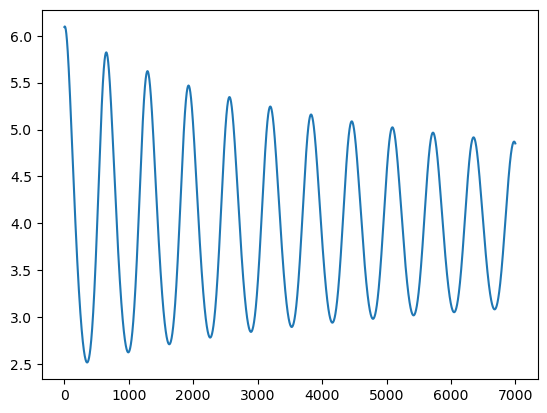

In [12]:
signal = results_1D[1,5,3000:,5,0,3].reshape(num_tsteps-3000)
plt.plot(signal.flatten())

#### Kymograph plots of Hes and Delta

In [ ]:
# Set up the figure and two axes for vertically stacked images
for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)
        h_flat = results_1D[i,j,2000:,:,0,0].reshape(num_tsteps-2000, lattice.P)
        d_flat = results_1D[i,j,2000:,:,0,2].reshape(num_tsteps-2000, lattice.P)

        # Plot the first image
        im1 = ax1.imshow(h_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(h_flat), vmax = np.ceil(np.max(h_flat)))
        ax1.set_ylabel('Time')
        ax1.set_xlabel('Cells')
        ax1.set_title('coupling strength = ' + str(coupling_strengths_1D[j]))

        # Add colorbar for the first image
        cbar1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.1, pad=0.2)
        cbar1.set_label('Hes values')

        # Plot the second image
        im2 = ax2.imshow(d_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(d_flat), vmax = np.ceil(np.max(d_flat)))
        ax2.set_title('coefficient = ' + str(coeff_1D[i]))

        # Add colorbar for the second image
        cbar2 = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.1, pad=0.2)
        cbar2.set_label('Delta values')

        #fig.savefig('1D_h_d_coeff_' + str(coeff_1D[i]) + '_coup_' + str(coupling_strengths_1D[j]) + '.png', dpi=300, bbox_inches='tight')

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_7724\3157078175.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3), constrained_layout=True)


KeyboardInterrupt: 

### Fix constant part of signal

In [13]:
time_analysis = int(2000)
time_amplitude = int(3*num_tsteps/4)

### Calculate decay ratios for the results

In [15]:
decay_ratios = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])

for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
        for k in range(lattice.P):
            signal = results_1D[j,i,time_analysis:,k,0,0].reshape(num_tsteps-time_analysis)
            signal = signal - np.mean(signal)
            signal = signal.flatten()  # remove DC component

            decay_ratios[i,j,k] = decay_ratio(signal, time_frame = 600)
    

# take the mean over all cells in P direction
decay_ratio_means = np.mean(decay_ratios, axis = 2)


### Calculate periods for the results

In [16]:
# find periods for the 1D system, per cell 
periods_peaks = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])
# periods_fft = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])
# periods_autocorr = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])


for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
        for p in range(lattice.P):
            signal = results_1D[j,i,time_analysis:,p,0,0].flatten()
            
            # find the period of the oscillation for each cell
            periods_peaks[i,j,p]= estimate_period_from_peaks(signal, time = np.arange(int(num_tsteps - time_analysis))*dt)[0]
            #periods_fft[i,j,p] = estimate_period_fft(signal, time = np.arange(int(num_tsteps - time_analysis))*dt)[0]
            #periods_autocorr[i,j,p] = estimate_period_autocorr(signal, time = np.arange(int(num_tsteps - time_analysis))*dt, height=None)[0]
            # amplitudes[i,j,p] = estimate_amplitude_from_peaks(signal, height=amplitude_threshold)[0]
            #amplitudes[i,j,p] = estimate_amplitude_from_peaks(signal)[0]

# calculate the average period of the signal over all cells
period_peaks_avg = np.mean(periods_peaks, axis = 2)

### Calculate amplitude for the last peaks of signal

In [18]:
amplitudes = np.zeros([len(coeff_1D), len(coupling_strengths_1D), lattice.P])

for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):
        for k in range(lattice.P):
            signal = results_1D[j,i,time_amplitude:,k,0,0].flatten()

            amplitudes[i,j,k] = estimate_amplitude_from_peaks(signal)[0]

amplitudes_mean = np.mean(amplitudes, axis =2)

### Calculate the propagation speed of the system with cross-correlation


In [18]:
spatial_signal = results_1D[3,40,:,:,0,0]

# Example signals (sine waves with a time shift)
t = np.linspace(0, num_tsteps*dt, num_tsteps)

y1 = spatial_signal[:,0]
y2 = spatial_signal[:,39]

# Compute the cross-correlation
cross_corr = np.correlate(y1, y2, mode='full')

# Time lags corresponding to the cross-correlation
lags = np.linspace(-t[-1], t[-1], len(cross_corr))

# Find the lag at which the cross-correlation is maximized
max_lag = lags[np.argmax(cross_corr)]

# Plot the signals and cross-correlation
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, y1, label='Signal 1')
plt.plot(t, y2, label='Signal 2', linestyle='--')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(lags, cross_corr)
plt.title(f'Cross-Correlation (Max Lag: {max_lag:.2f}s)')
plt.xlabel('Lag (seconds)')
plt.ylabel('Cross-Correlation')

plt.tight_layout()
plt.show()

# Print the estimated lag
print(f"Estimated time lag: {max_lag:.2f} seconds")

IndexError: index 40 is out of bounds for axis 1 with size 7

In [35]:
# Example spatial separation
delta_x = 40  # meters

# Compute the propagation speed
v = delta_x / max_lag
print(f"Estimated propagation speed: {v:.2f} m/s")


Estimated propagation speed: -0.68 m/s


### Calculate the spatial wavelength of the system 

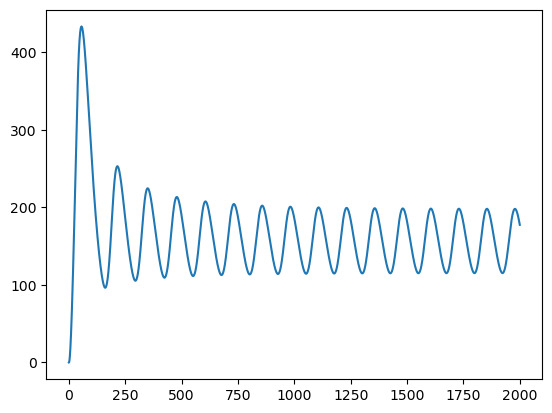

In [21]:
spatial_signal = results_1D[0,0,:,:,0,0]

plt.plot(np.arange(num_tsteps)*dt, spatial_signal[:,0])

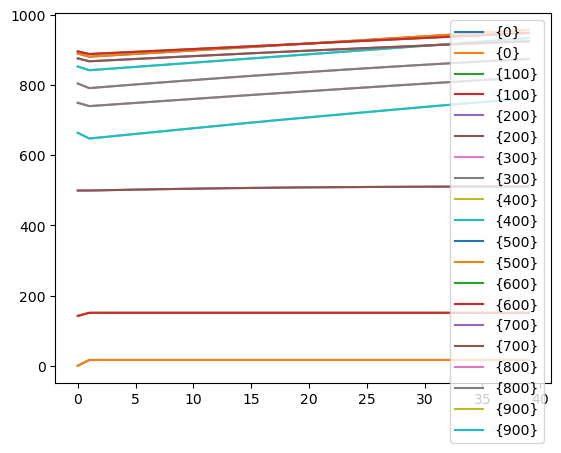

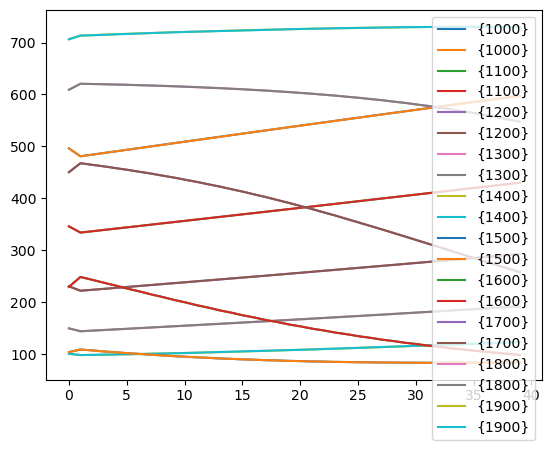

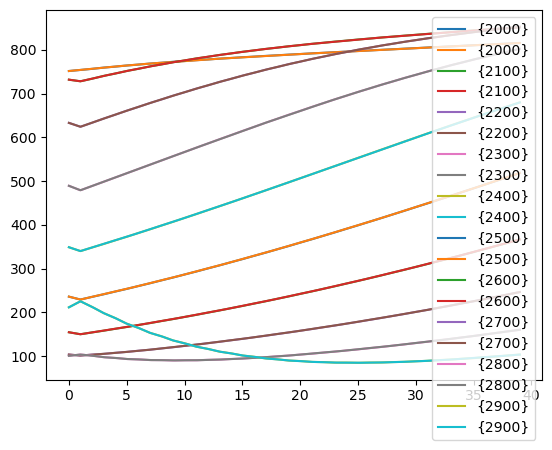

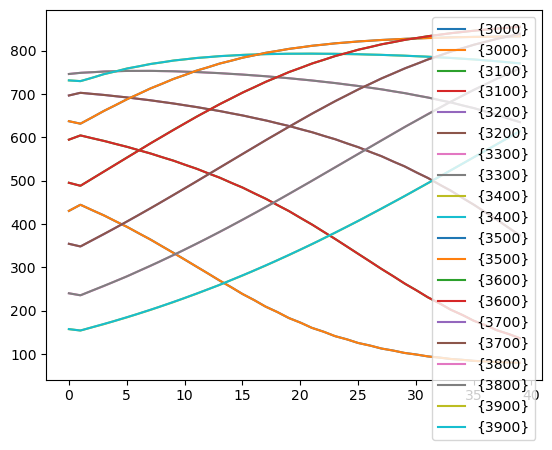

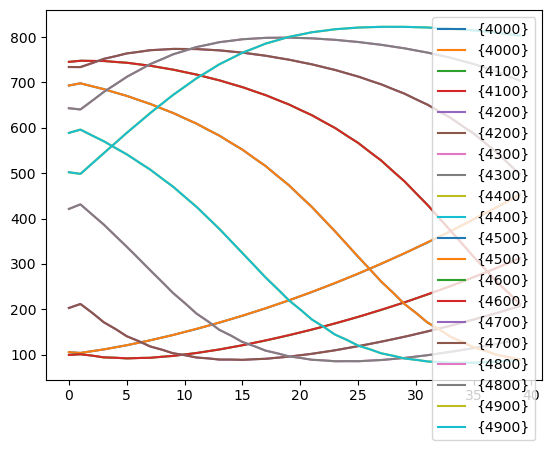

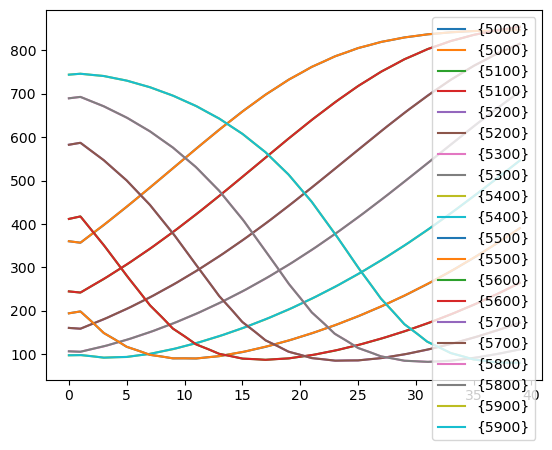

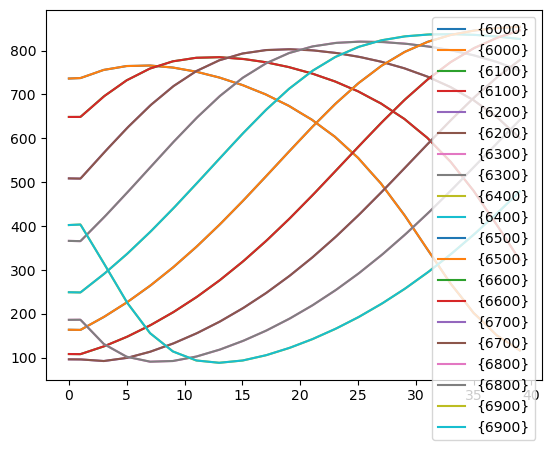

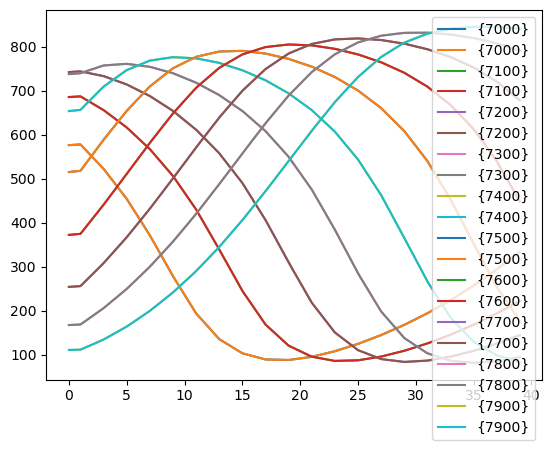

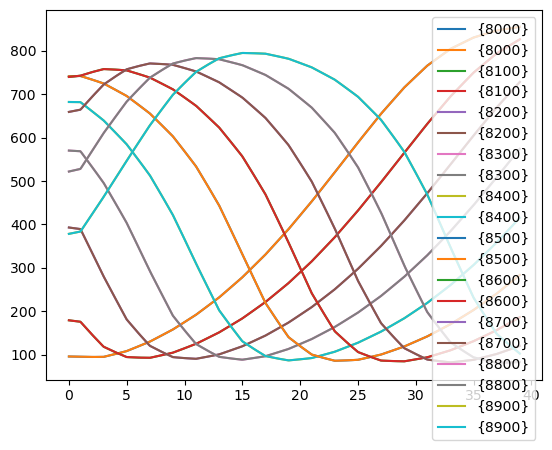

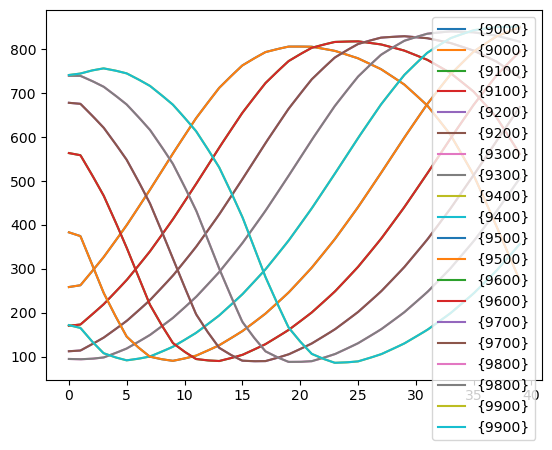

In [10]:
from scipy.ndimage import uniform_filter1d
from scipy.interpolate import interp1d

spatial_signal = results_1D[0,0,:,:,0,0]
spatial_signal_smooth = np.zeros((num_tsteps, lattice.P))
spatial_signal_smooth_interp = np.zeros((num_tsteps, lattice.P*10))

for i in range(num_tsteps):
    spatial_signal_smooth[i,:] = uniform_filter1d(spatial_signal[i,:], size=2, mode='reflect')

    #interpolate the signal to get a smoother signal
    interp = interp1d(np.arange(lattice.P), spatial_signal_smooth[i,:], kind='linear', fill_value='extrapolate')
    x_new = np.linspace(0, lattice.P-1, num=lattice.P*10)
    spatial_signal_smooth_interp[i,:] = interp(x_new)

for z in range(10):
    plt.figure()
    for t in range(10):
        #plt.plot(spatial_signal[t*100+z*1000,:], label = {t*100+z*1000})
        plt.plot(spatial_signal_smooth[t*100+z*1000,:], label = {t*100+z*1000})  
        plt.plot(x_new, spatial_signal_smooth_interp[t*100+z*1000,:], label = {t*100+z*1000})
    plt.legend()

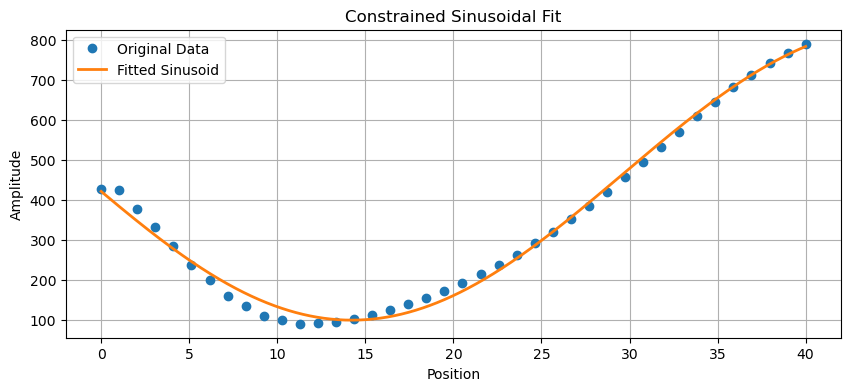

Estimated wavelength: 61.64755058019388


In [123]:
from scipy.optimize import curve_fit

def sinusoid(x, A, f, phi, offset):
    return A * np.sin(2 * np.pi * f * x + phi) + offset

x_data = np.linspace(0, lattice.P, 40)
y_data = spatial_signal_smooth[9965, :]

# Try to guide it better: wavelength ~ 80 → freq ~ 1/80
initial_guess = [np.ptp(y_data) / 2, 1/80, 0, np.mean(y_data)]

# Limit frequency between [1/200, 1/40] to avoid wild fits
bounds = ([0, 1/200, -np.pi, 0], [np.inf, 1/20, np.pi, np.inf])

popt, _ = curve_fit(sinusoid, x_data, y_data, p0=initial_guess, bounds=bounds)

# Plot the result
x_fit = np.linspace(0, lattice.P, 1000)
y_fit = sinusoid(x_fit, *popt)

plt.figure(figsize=(10, 4))
plt.plot(x_data, y_data, 'o', label='Original Data')
plt.plot(x_fit, y_fit, '-', label='Fitted Sinusoid', linewidth=2)
plt.legend()
plt.grid(True)
plt.title('Constrained Sinusoidal Fit')
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.show()

# Final estimated wavelength
estimated_wavelength = 1 / popt[1]
print("Estimated wavelength:", estimated_wavelength)

In [ ]:
# finding the signals using zero crossings and peaks 

spatial_signal = results_1D[3,40,:,:,0,0]
spatial_signal_smooth = np.zeros((num_tsteps, lattice.P))
time_wavelengths = 9990 #int(9*num_tsteps/10)
mean_signal_time = np.zeros(lattice.P)

mean_signal_time[p] = np.mean(results_1D[3,40,time_wavelengths:,p,0,0].flatten())

for t in range(num_tsteps - time_wavelengths):
    i = t + time_wavelengths
    spatial_signal_smooth[i,:] = uniform_filter1d(spatial_signal[i,:], size=2, mode='reflect')
    spatial_signal_smooth[i,:] = spatial_signal_smooth[i,:] - mean_signal_time[:]

    if i % 10 == 0:
        plt.figure()
        plt.plot(spatial_signal_smooth[i,:], label = {i})
        plt.legend()


def find_zero_crossings(signal):
    """
    Find the indices of zero crossings in a 1D signal.
    """
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return zero_crossings



C:\Users\kbmcd\AppData\Local\Temp\ipykernel_10584\1295724455.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Error in callback <function _draw_all_if_interactive at 0x000002D74A7C9E10> (for post_execute):


9500
9510
9520
9530
9540
9550
9560
9570
9580
9590
9600
9610
9620
9630
9640
9650
9660
9670
9680
9690
9700
9710
9720
9730
9740
9750
9760
9770
9780
9790
9800
9810
9820
9830
9840
9850
9860
9870
9880
9890
9900
9910
9920
9930
9940
9950
9960
9970
9980
9990


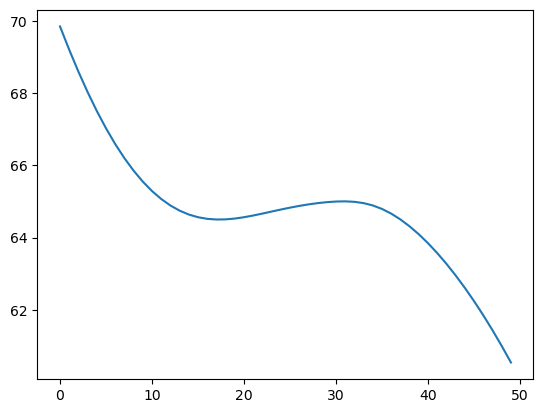

In [ ]:
from scipy.ndimage import uniform_filter1d


def try_fit_with_guesses(x_data, y_data, guesses, bounds, maxfev=1000):
    best_popt = None
    best_pcov = None
    best_score = np.inf

    for guess in guesses:
        try:
            popt_i, pcov_i = curve_fit(
                sinusoid, x_data, y_data,
                p0=guess,
                bounds=bounds,
                maxfev=maxfev
            )
            # Calculate residual sum of squares (RSS)
            residuals = y_data - sinusoid(x_data, *popt_i)
            rss = np.sum(residuals**2)

            if rss < best_score:
                best_score = rss
                best_popt = popt_i
                best_pcov = pcov_i

        except Exception as e:
            continue  # Skip failed fit

    return best_popt, best_pcov
spatial_signal = results_1D[3,40,:,:,0,0]
spatial_signal_smooth = np.zeros((num_tsteps, lattice.P))

# smoothen the signals 
for i in range(num_tsteps):
    spatial_signal_smooth[i,:] = uniform_filter1d(spatial_signal[i,:], size=2, mode='reflect')

x_data = np.linspace(0, lattice.P, 40)  # x data points

# Create lists to store the results for each timestep
wavelengths = []
fitted_params = []

signal_popts = np.zeros((50, 4))  # best-fit parameters
signal_perrs = np.zeros((50, 4))  # parameter errors

for i in range(50):
    s = num_tsteps - 500 + i*10
    print(s)
    y_data = spatial_signal_smooth[s, :]
    
    initial_guesses = [
    [np.ptp(y_data) / 2, 1/80, 0, np.mean(y_data)],
    [np.ptp(y_data) / 2, 1/60, np.pi/4, np.mean(y_data)],
    [np.ptp(y_data) / 2, 1/40, 0, np.mean(y_data)]]

    popt_i, pcov_i = try_fit_with_guesses(x_data, y_data, initial_guesses, bounds)

    if popt_i is not None:
        perr_i = np.sqrt(np.diag(pcov_i))
        signal_popts[i] = popt_i
        signal_perrs[i] = perr_i
        wavelengths.append(1 / popt_i[1])
    else:
        print(f"Both fits failed at timestep {s}")
        signal_popts[i] = np.full(4, np.nan)
        signal_perrs[i] = np.full(4, np.nan)
        wavelengths.append(np.nan)
    bounds = ([0, 1/200, -np.pi, 0], [np.inf, 1/40, np.pi, np.inf])

plt.plot(wavelengths)


### Calculate the point until lateral inhibition

for i: 0 j: 0 lat inhib: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
for i: 0 j: 1 lat inhib: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
for i: 0 j: 2 lat inhib: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
for i: 0 j: 3 lat inhib: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
for i: 0 j: 4 lat inhib: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
for i: 0 j: 5 lat inhib: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
for i: 0 j: 6 lat inhib: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

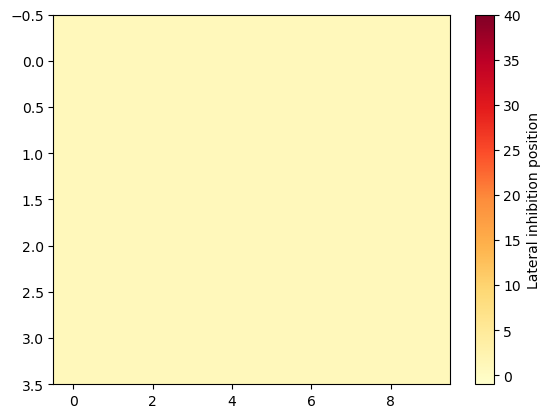

In [28]:
def lateral_inhibition(d, amplitude):
    lateral_inhibition = np.zeros(P-1)

    d_mean = np.mean(d[:,:], axis = 0)
    d_diff = np.abs(np.diff(d_mean, axis = 0).flatten())

    amplitude = (amplitude[1:] + amplitude[:-1])/2

    d_ratio = d_diff/amplitude

    #determine lateral inhibition based on d_ratio and amplitude
    for i in range(0, P-1):
        if np.isnan(amplitude[i]):
            if d_diff[i] == 0:
                lateral_inhibition[i] = -1
                print('we seem to have constant values for two cells')
            else:
                lateral_inhibition[i] = 1
        elif d_ratio[i] > 1e-3:
            lateral_inhibition[i] = 1
        else:
            lateral_inhibition[i] = 0

        position = np.where(lateral_inhibition == 0)[0]

        return lateral_inhibition, position


lat_inhib_pos = np.zeros([len(coeff_1D), len(coupling_strengths_1D), 2])

for i in range(len(coeff_1D)):
    for j in range(len(coupling_strengths_1D)):

        signal = results_1D[i,j,time_amplitude:,:,0,0].reshape(num_tsteps - time_amplitude, lattice.P)

        positions = lateral_inhibition(signal, amplitudes[i,j])[1]
        print('for i:', i, 'j:', j, 'lat inhib:', lateral_inhibition(signal, amplitudes[i,j])[0])
        
        if len(positions) == 0:
            lat_inhib_pos[i,j,0] = -1
            lat_inhib_pos[i,j,1] = -1
        else:
            lat_inhib_pos[i,j,0] = positions[0]
            lat_inhib_pos[i,j,1] = positions[-1]

print(lat_inhib_pos.shape)

plt.imshow(lat_inhib_pos[:,:,0], aspect = 'auto', cmap='YlOrRd', vmin = -1, vmax = 40)
plt.colorbar(label='Lateral inhibition position')

print('Lateral inhibition position:', lat_inhib_pos[:,:,1])



### Plot the mean decay rate, period and final amplitude

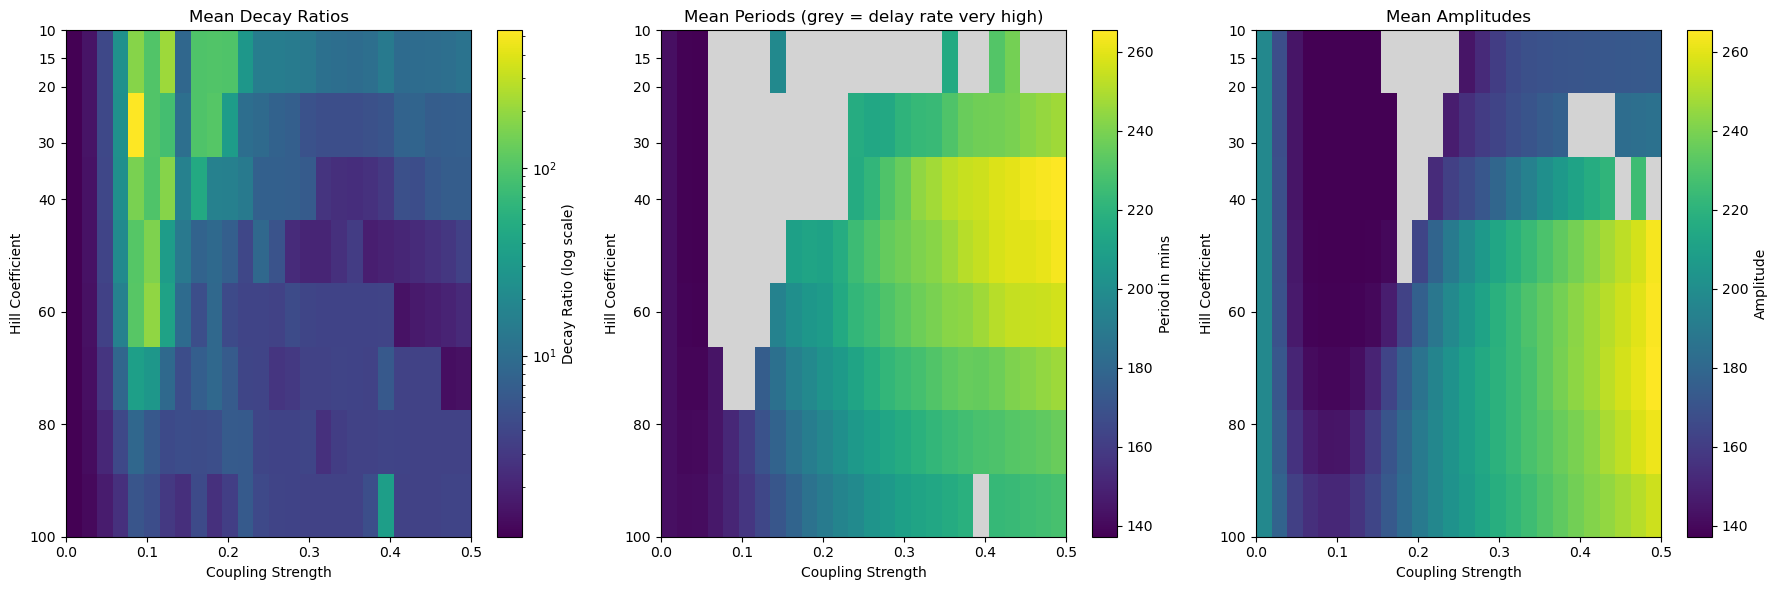

In [19]:
# Set up the figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ======== Plot 1: Decay Ratios (log scale) ========
im1 = axes[0].imshow(decay_ratio_means, 
                     aspect='auto', 
                     interpolation='none', 
                     norm=LogNorm(vmin=np.min(decay_ratio_means[decay_ratio_means > 0]), 
                                  vmax=np.max(decay_ratio_means)),
                     extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], 
                             coeff_1D[-1], coeff_1D[0]])
axes[0].set_title('Mean Decay Ratios')
axes[0].set_xlabel('Coupling Strength')
axes[0].set_ylabel('Hill Coefficient')
axes[0].set_yticks(coeff_1D)
fig.colorbar(im1, ax=axes[0], label='Decay Ratio (log scale)')

# ======== Plot 2: Periods (masked by decay) ========
masked_periods = np.ma.masked_where(decay_ratio_means > 10, period_peaks_avg)
cmap = cm.viridis.copy()
cmap.set_bad(color='lightgrey')

im2 = axes[1].imshow(masked_periods, 
                     aspect='auto', 
                     interpolation='none', 
                     cmap=cmap,
                     extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], 
                             coeff_1D[-1], coeff_1D[0]])

axes[1].set_title('Mean Periods (grey = delay rate very high)')
axes[1].set_xlabel('Coupling Strength')
axes[1].set_ylabel('Hill Coefficient')
axes[1].set_yticks(coeff_1D)
fig.colorbar(im2, ax=axes[1], label='Period in mins')

# ======== Plot 3: Amplitudes ========
im3 = axes[2].imshow(amplitudes_mean, 
                     aspect='auto', 
                     interpolation='none', 
                     cmap=cmap,
                     extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], 
                             coeff_1D[-1], coeff_1D[0]])

axes[2].set_title('Mean Amplitudes')
axes[2].set_xlabel('Coupling Strength')
axes[2].set_ylabel('Hill Coefficient')
axes[2].set_yticks(coeff_1D)
fig.colorbar(im2, ax=axes[2], label='Amplitude')

plt.tight_layout()
plt.show()

### Relation between Coupling Strength and period

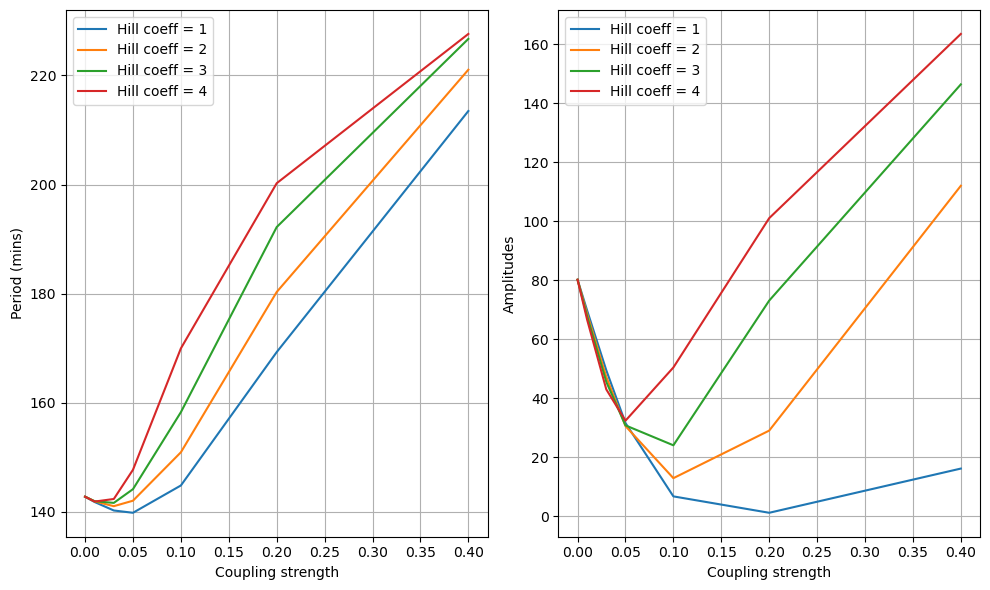

In [11]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
for n in range(len(coeff_1D)):
    plt.plot(coupling_strengths_1D, period_peaks_avg[n,:], label = f'Hill coeff = {n+1}')
plt.xlabel('Coupling strength')
plt.ylabel('Period (mins)')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
for n in range(len(coeff_1D)):
    plt.plot(coupling_strengths_1D, amplitudes_mean[n,:], label = f'Hill coeff = {n+1}')
plt.xlabel('Coupling strength')
plt.ylabel('Amplitudes')
plt.grid()
plt.legend()

plt.tight_layout()


#### All plots for decay ratio

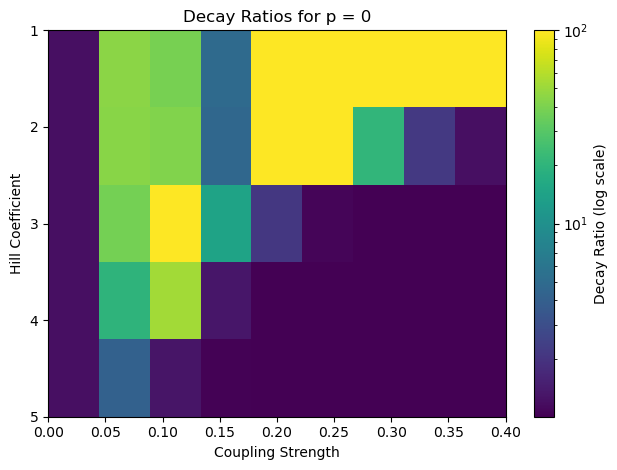

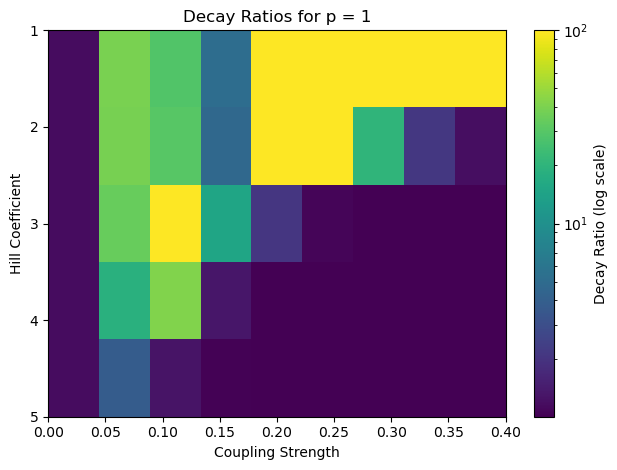

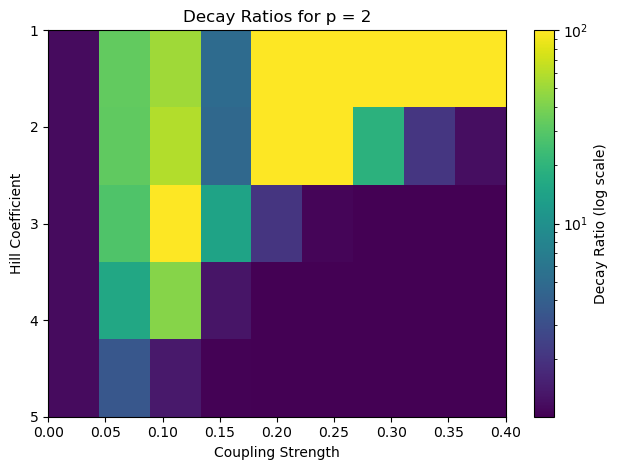

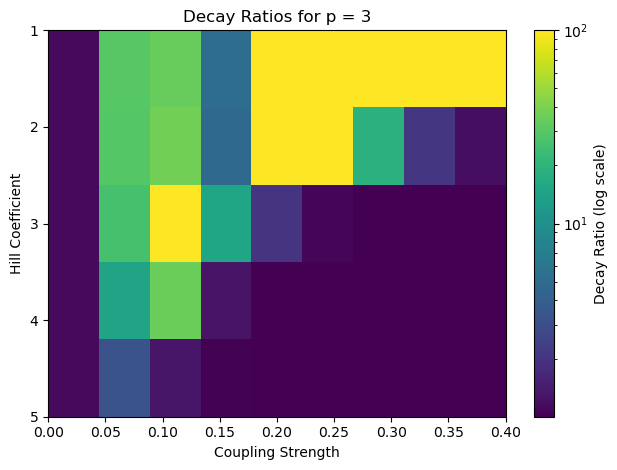

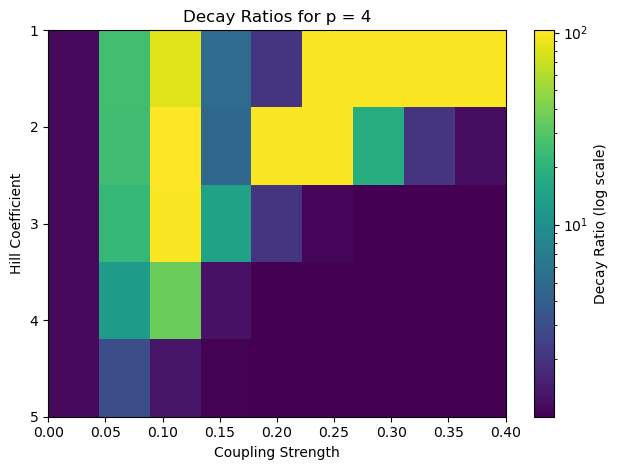

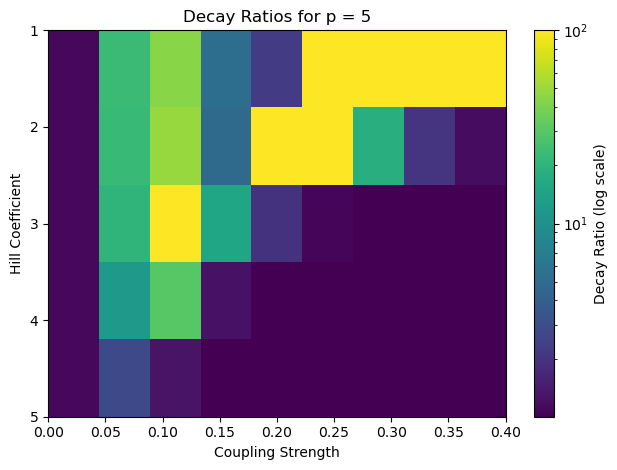

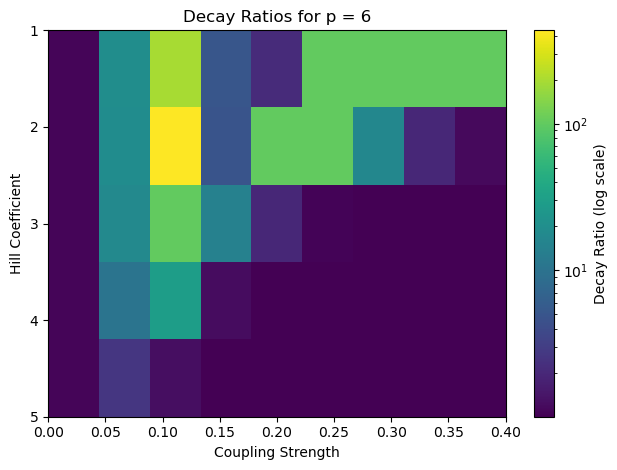

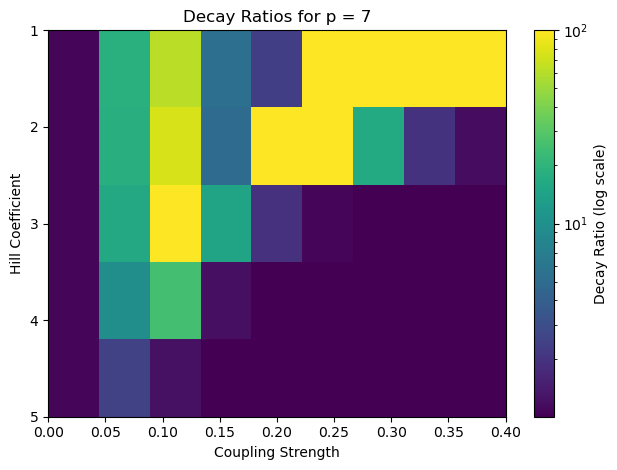

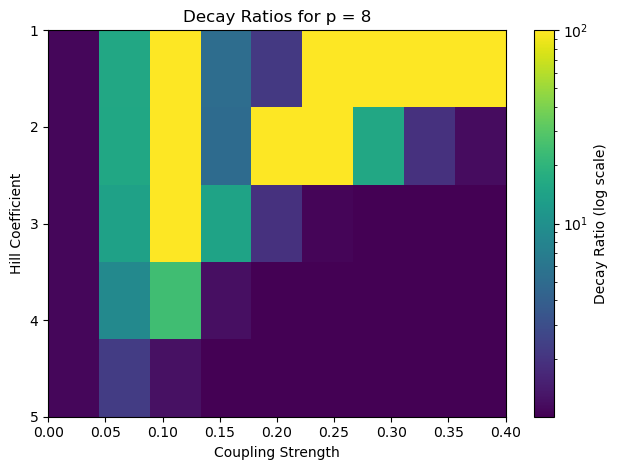

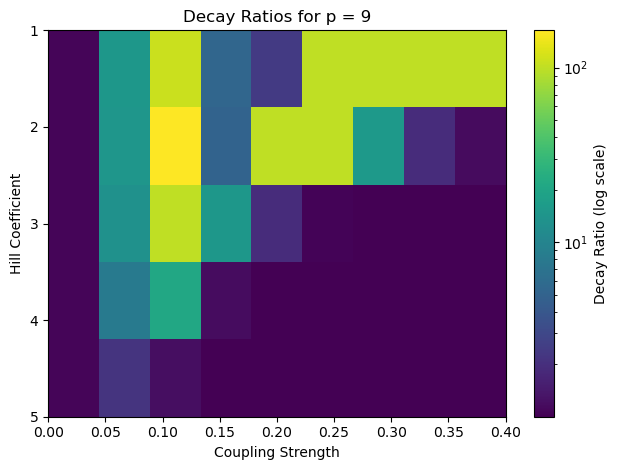

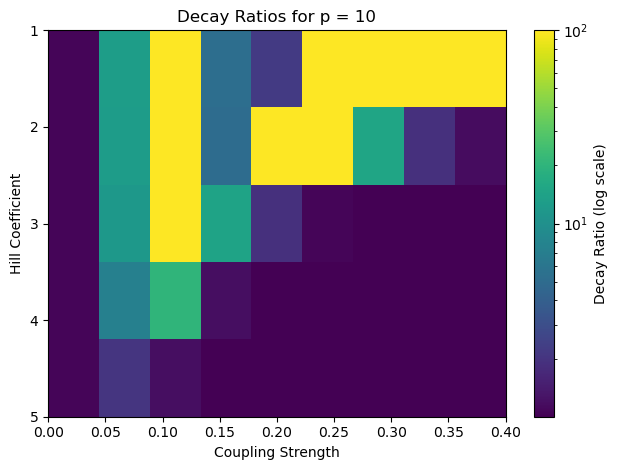

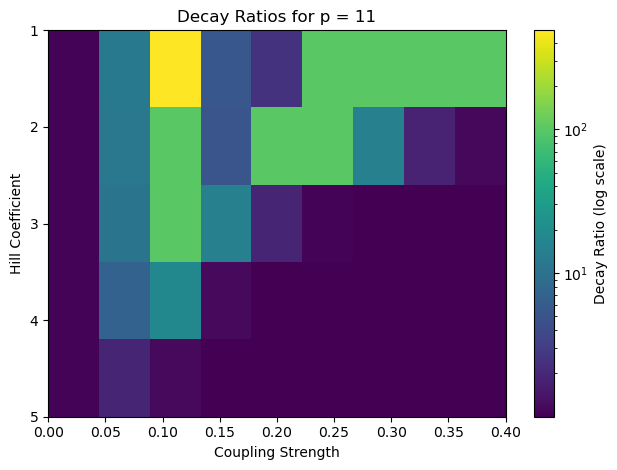

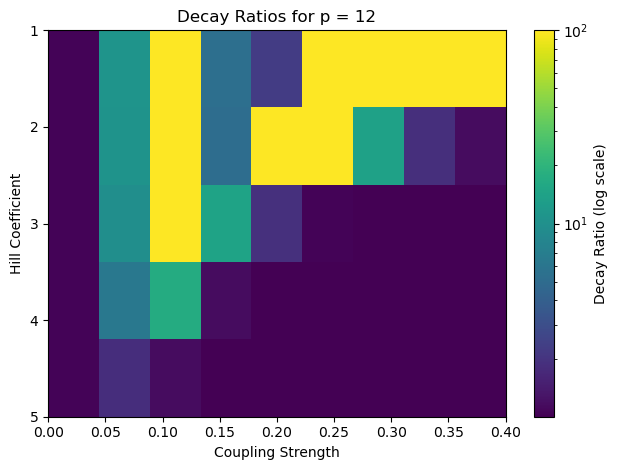

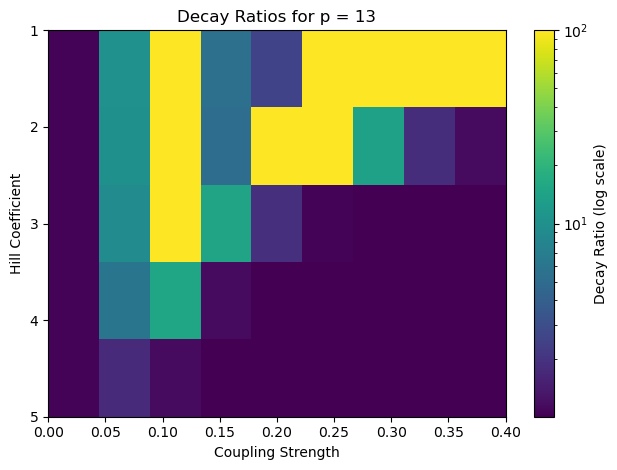

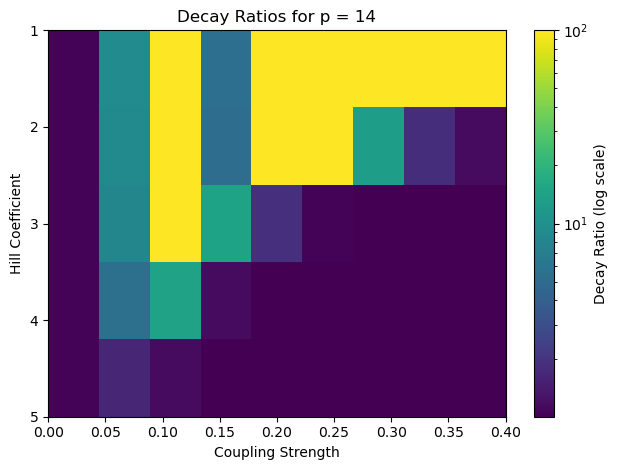

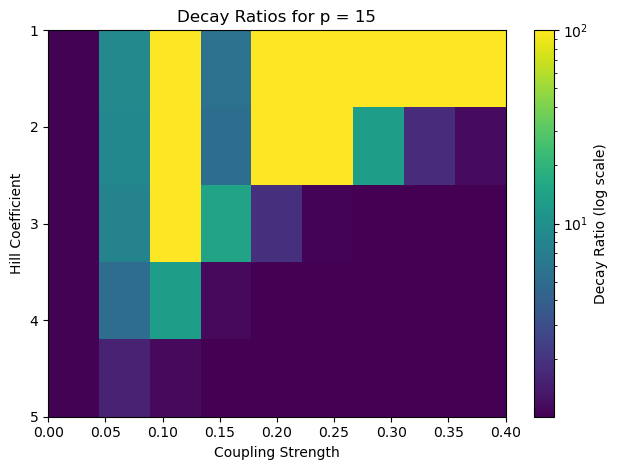

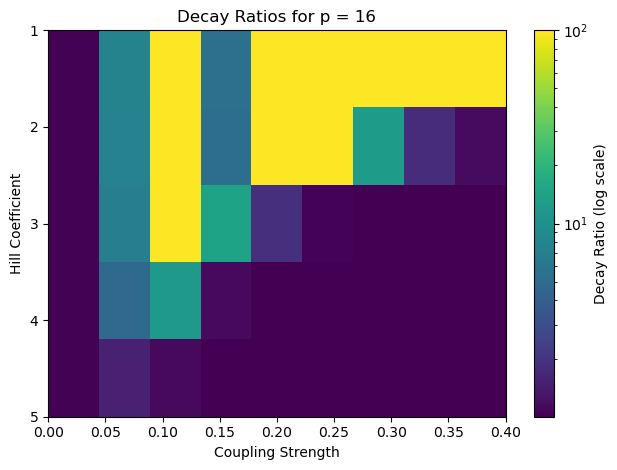

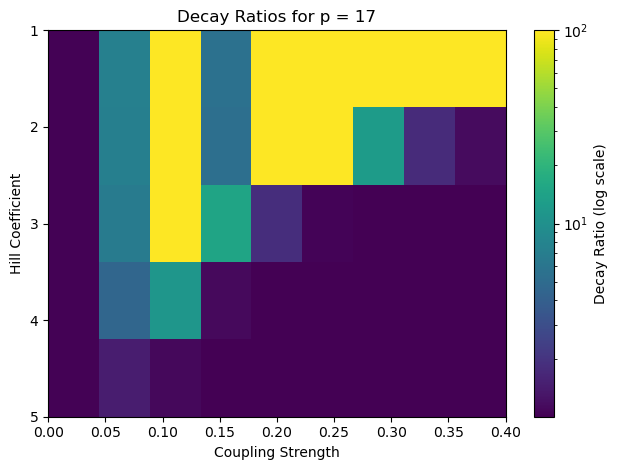

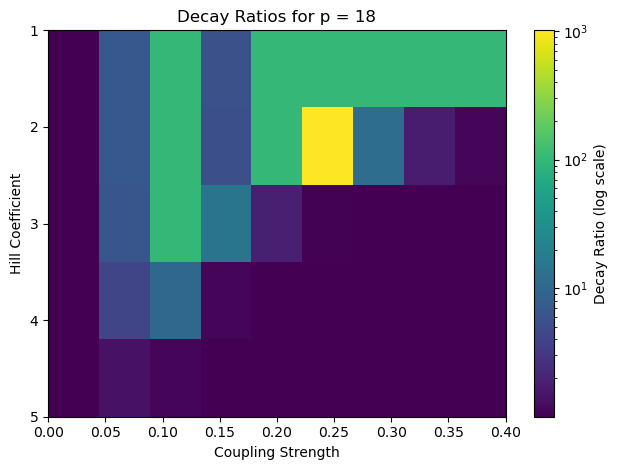

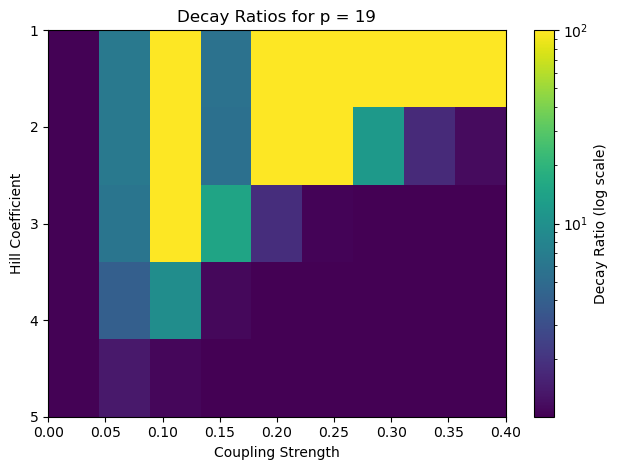

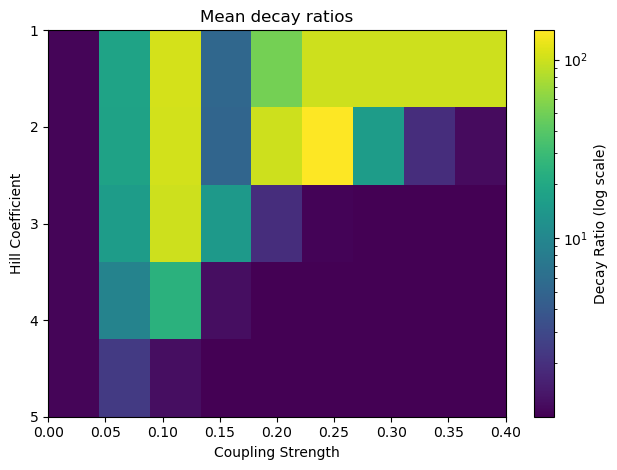

In [ ]:

for k in range(lattice.P): 
    decay_ratio_k = decay_ratios[:,:,k]

    plt.figure()

    # Apply logarithmic color scale
    plt.imshow(decay_ratio_k, 
            aspect='auto', 
            interpolation='none', 
            norm=LogNorm(vmin=np.min(decay_ratio_k[decay_ratio_k > 0]), vmax=np.max(decay_ratio_k)),
            extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], coeff_1D[-1], coeff_1D[0]])

    plt.colorbar(label='Decay Ratio (log scale)')
    plt.xlabel('Coupling Strength')
    plt.ylabel('Hill Coefficient')
    plt.title(f'Decay Ratios for p = {k}')

    # Set y-ticks explicitly
    plt.yticks([1, 2, 3, 4, 5])

    plt.tight_layout()
    plt.show()

plt.figure()


# Apply logarithmic color scale
plt.imshow(decay_ratio_means, 
        aspect='auto', 
        interpolation='none', 
        norm=LogNorm(vmin=np.min(decay_ratio_means[decay_ratio_means > 0]), vmax=np.max(decay_ratio_means)),
        extent=[coupling_strengths_1D[0], coupling_strengths_1D[-1], coeff_1D[-1], coeff_1D[0]])

plt.colorbar(label='Decay Ratio (log scale)')
plt.xlabel('Coupling Strength')
plt.ylabel('Hill Coefficient')
plt.title(f'Mean decay ratios')

# Set y-ticks explicitly
plt.yticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

#### All plots for peak period

In [ ]:
for k in range(lattice.P): 
    periods_k = periods_peaks[:,:,k]
    
    plt.figure()

    # Apply logarithmic color scale
    plt.imshow(periods_k, 
            aspect='auto', 
            interpolation='none')

    plt.colorbar(label='Period in mins')
    plt.xlabel('Coupling Strength')
    plt.ylabel('Hill Coefficient')
    plt.title(f'Periods p = {k}')

    # Set y-ticks explicitly
    plt.yticks([1, 2, 3, 4, 5])

    plt.tight_layout()
    plt.show()

plt.figure()

# take the mean over all cells in P direction

# Apply logarithmic color scale
plt.imshow(period_peaks_avg, 
        aspect='auto', 
        interpolation='none')

plt.colorbar(label='Period in mins')
plt.xlabel('Coupling Strength')
plt.ylabel('Hill Coefficient')
plt.title(f'Mean periods')

# Set y-ticks explicitly
plt.yticks([1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

### Different types of period calculation

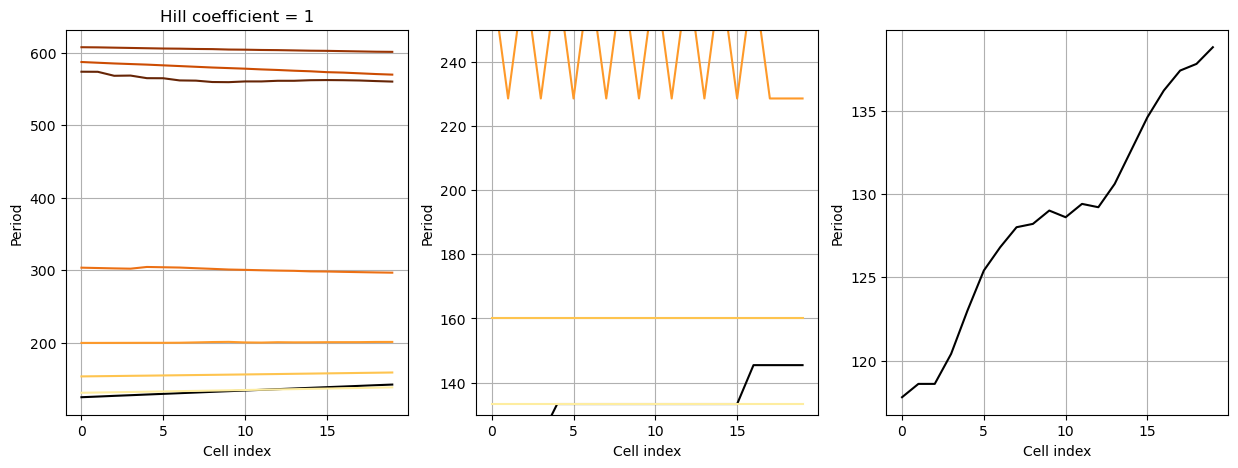

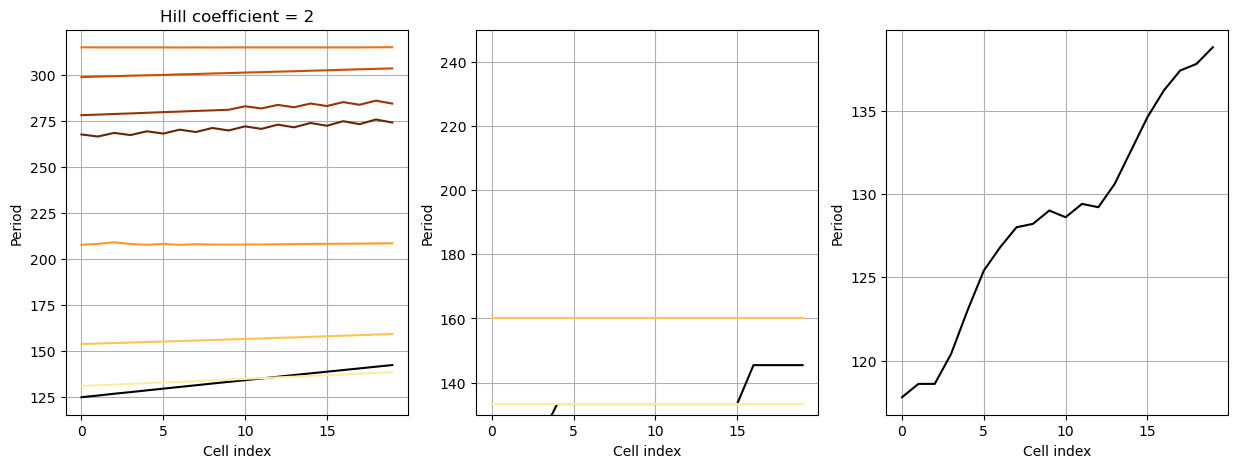

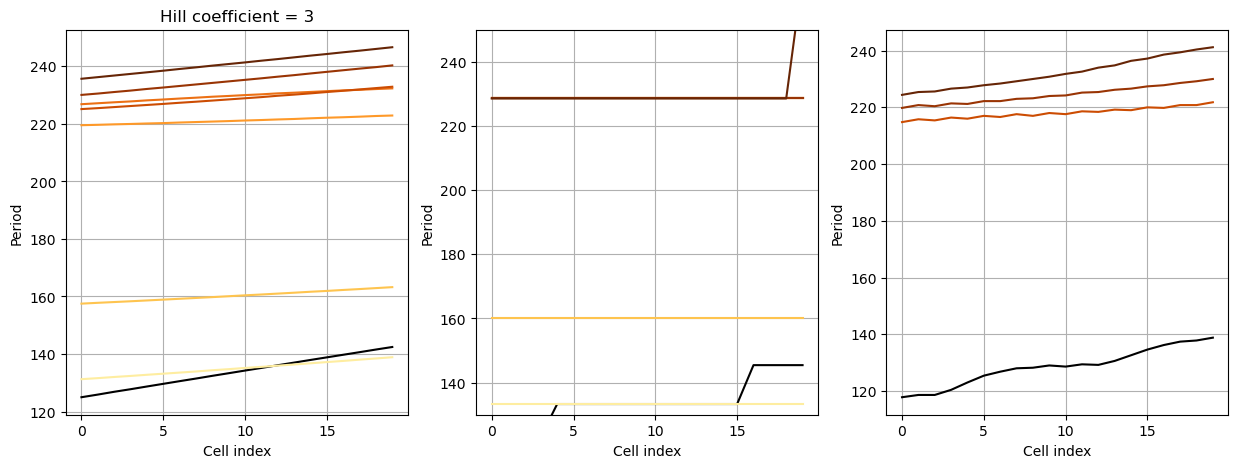

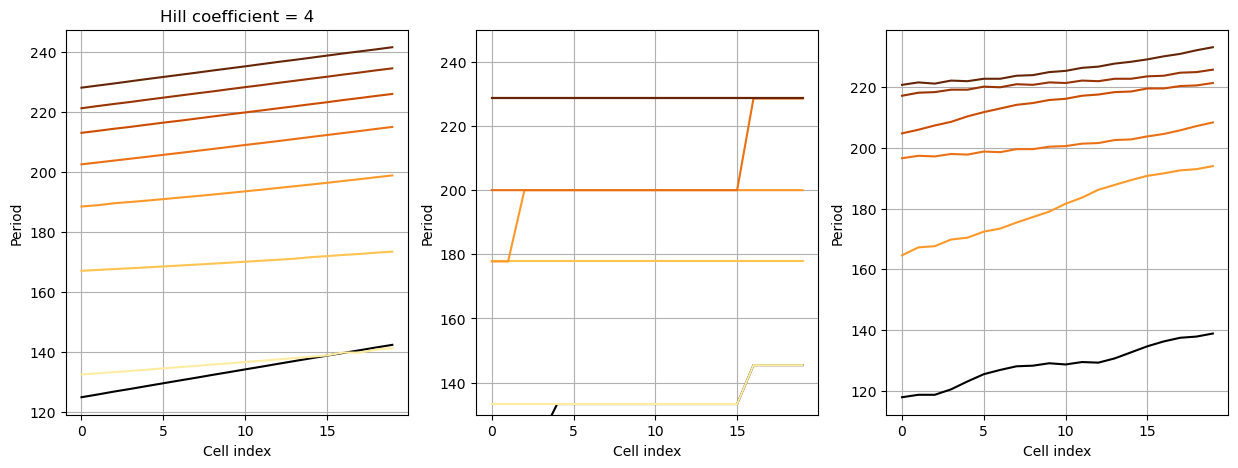

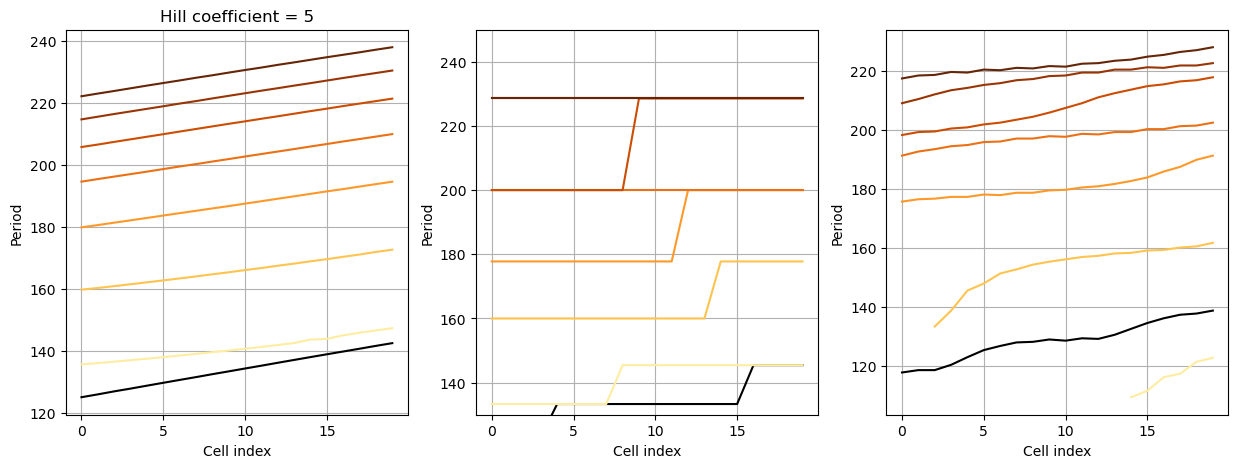

In [7]:
colors_coeffs = ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#bd0026']
colors_strengths = ['#feeda0', '#fec44f', '#fe9929', '#ec7014', '#cc4c02', '#993404', '#662506']


for i in range(len(coeff_1D)):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(lattice.P), periods_peaks[0,0,:], label = 'no coupling periods', color = 'black')
    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()
    
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_peaks[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')
    plt.title(f'Hill coefficient = {coeff_1D[i]}')


    plt.subplot(1,3,2)
    plt.plot(np.arange(lattice.P), periods_fft[0,0,:], label = 'no coupling periods', color = 'black')
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_fft[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')
    plt.ylim(130,250)
    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()

    plt.subplot(1,3,3)
    plt.plot(np.arange(lattice.P), periods_autocorr[0,0,:], label = 'no coupling periods', color = 'black')
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_autocorr[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')

    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()

### Plot periods + amplitude + kymograph for each n

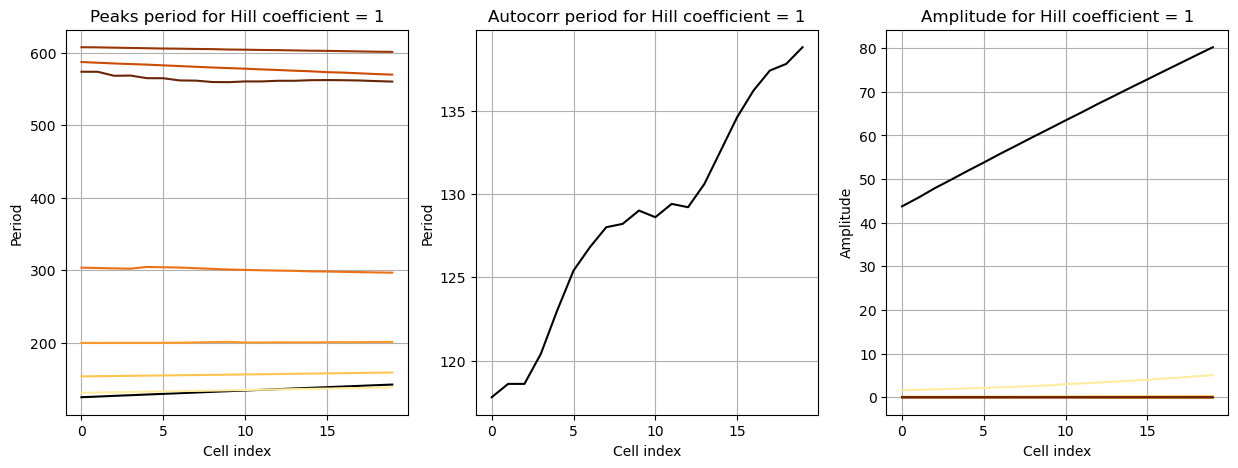

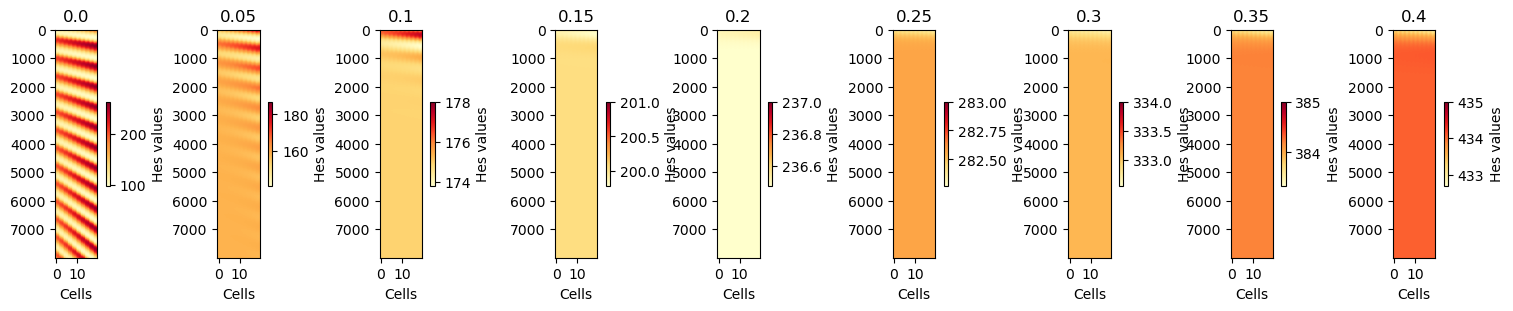

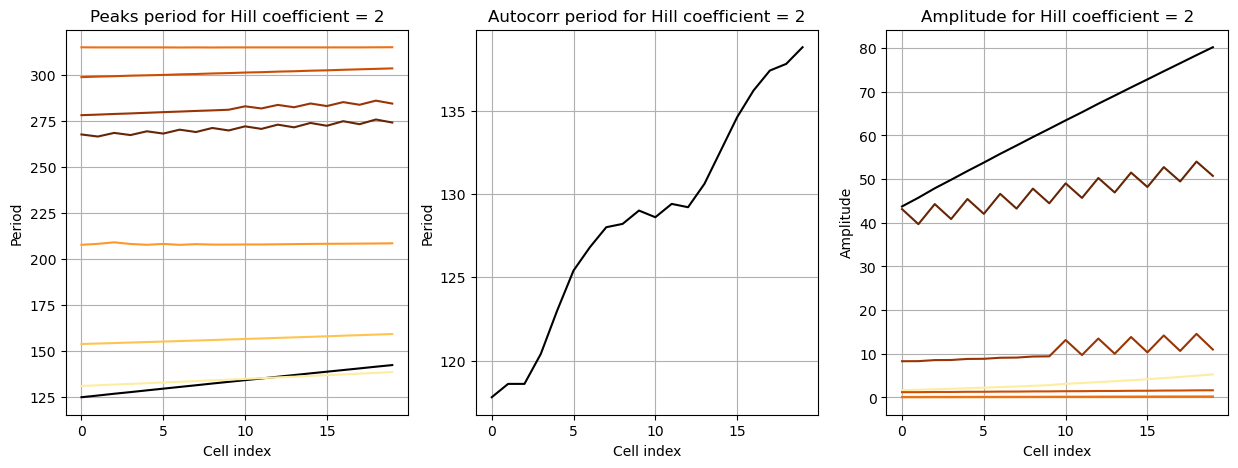

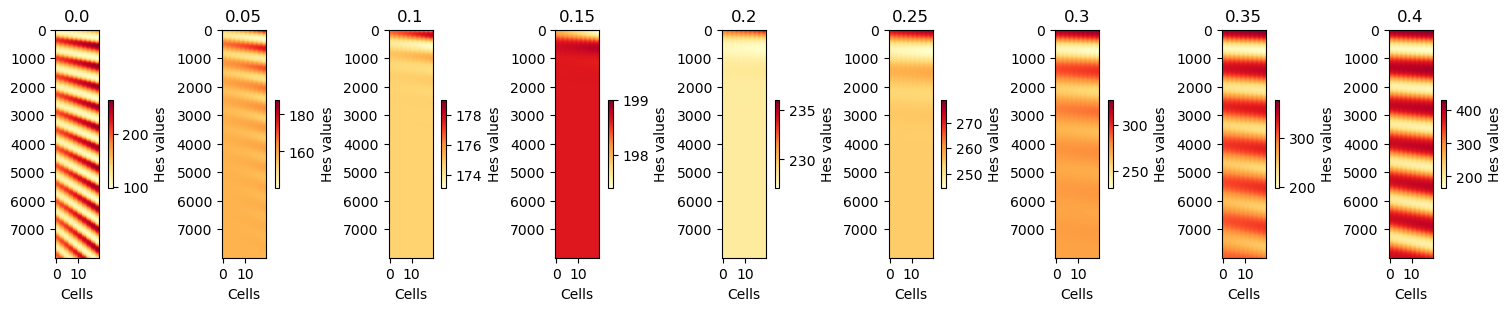

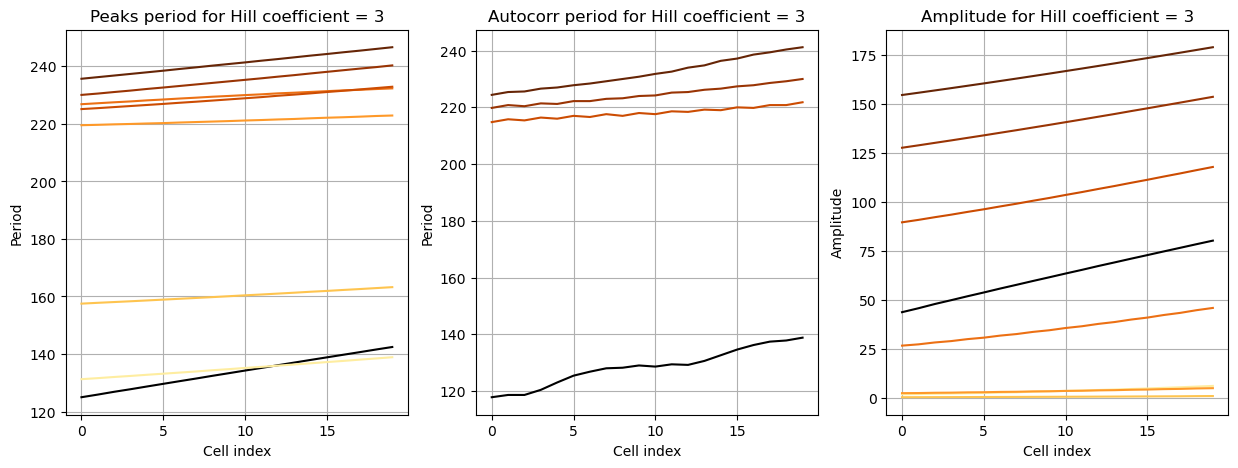

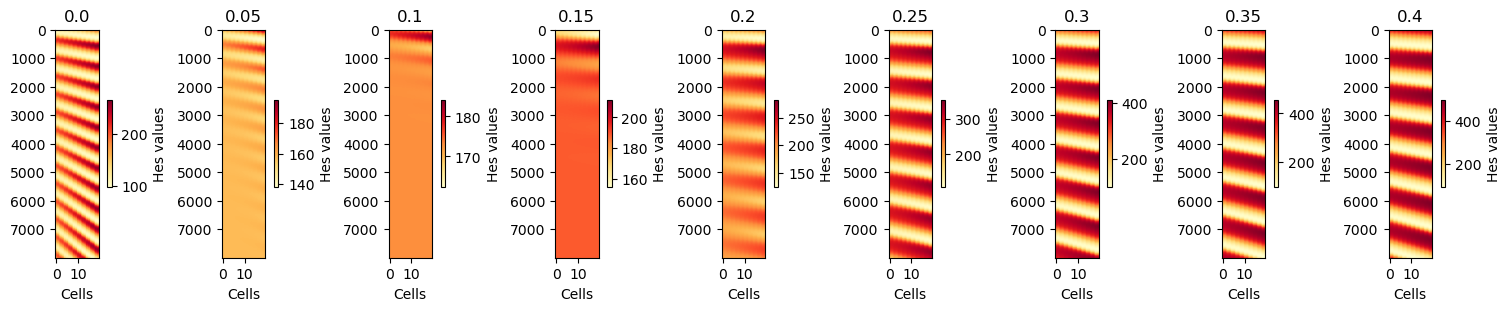

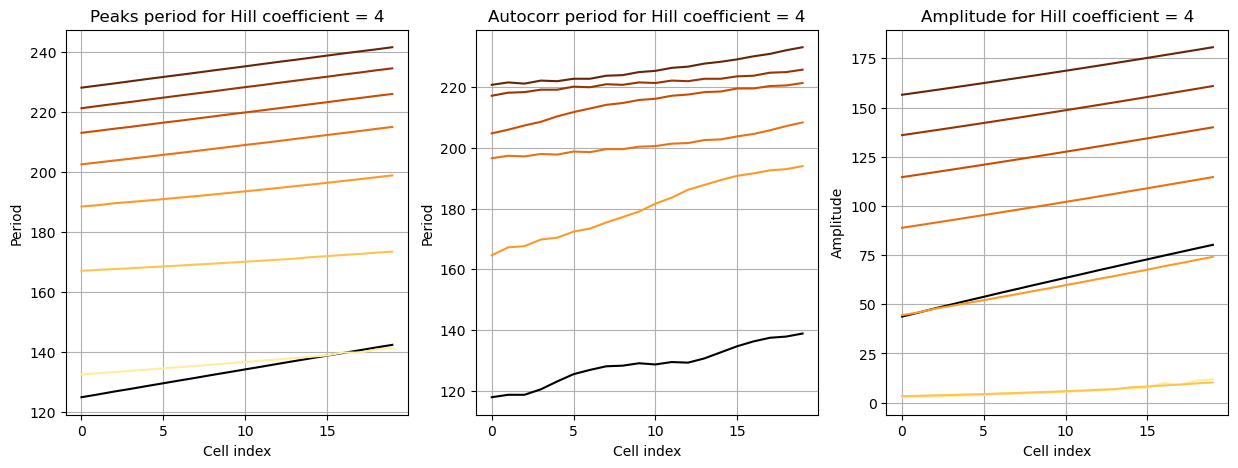

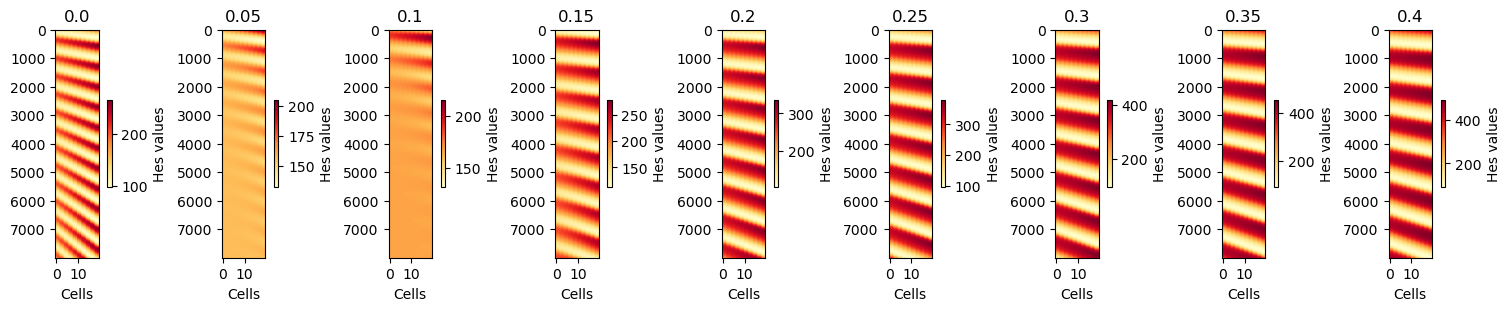

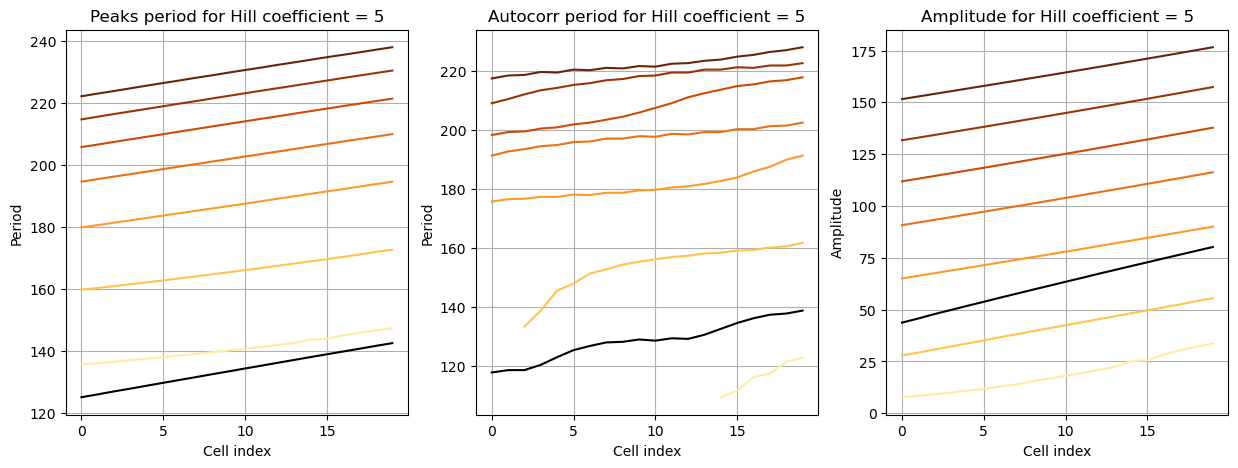

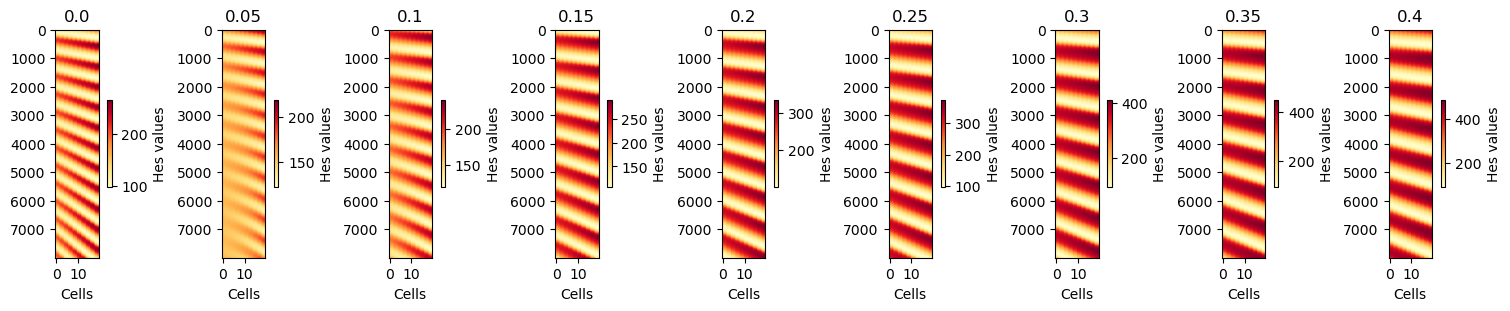

In [ ]:
for i in range(len(coeff_1D)):
    #plot of periods with peaks 
    plt.figure(figsize=(15,5))

    plt.subplot(1, 3, 1)
    plt.title(f'Peaks period for Hill coefficient = {coeff_1D[i]}')
    plt.plot(np.arange(lattice.P), periods_peaks[0,0,:], label = 'no coupling periods', color = 'black')
    plt.xlabel('Cell index')
    plt.ylabel('Period')
    plt.grid()
    
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), periods_peaks[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')


    # # plot of periods with autocorrelation
    # plt.subplot(1,3,2)
    # plt.title(f'Autocorr period for Hill coefficient = {coeff_1D[i]}')
    # plt.plot(np.arange(lattice.P), periods_autocorr[0,0,:], label = 'no coupling periods', color = 'black')

    # for j in range(1, len(coupling_strengths_1D)-1):
    #     plt.plot(np.arange(lattice.P), periods_autocorr[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')

    # plt.xlabel('Cell index')
    # plt.ylabel('Period')
    # plt.grid()
 

    # plot of amplitudes 
    plt.subplot(1,3,3)
    plt.title(f'Amplitude for Hill coefficient = {coeff_1D[i]}')
    plt.plot(np.arange(lattice.P), amplitudes[0,0,:], label = 'no coupling periods', color = 'black')
    for j in range(1, len(coupling_strengths_1D)-1):
        plt.plot(np.arange(lattice.P), amplitudes[i,j,:], color = colors_strengths[j-1], label = f'coeff = {coeff_1D[i]}, coup_strength = {coupling_strengths_1D[j]}')
    plt.xlabel('Cell index')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()

    #plot the kymograph for the different coupling strengths
    fig, ax = plt.subplots(1, int(len(coupling_strengths_1D)), figsize=(15,3), constrained_layout=True)

    for j in range(len(coupling_strengths_1D)):

        h_flat = results_1D[i,j,int(time_analysis):,:,0,0].reshape(int(num_tsteps-time_analysis), lattice.P)

        # Plot the first image
        im_j = ax[j].imshow(h_flat, aspect = 'auto',  cmap='YlOrRd', vmin = np.min(h_flat), vmax = np.ceil(np.max(h_flat)))
        #ax[j].set_ylabel('Time')
        ax[j].set_xlabel('Cells')
        ax[j].set_title(str(round(coupling_strengths_1D[j],2)))

        # Add colorbar for the first image
        cbar1 = fig.colorbar(im_j, ax=ax[j], orientation='vertical', fraction=0.1, pad=0.2)
        cbar1.set_label('Hes values')

    plt.show()



## Phase space 

In [19]:
for i in range(lattice.P):
    plt.figure()
    for j in range(lattice.Q):
        q_test = j
        plt.plot(m_h[:,i,q_test], m_d[:,i,q_test],  label = 'for P = ' + str(i))
    plt.xlabel('m_h')
    plt.ylabel('m_d')
    plt.legend()
    plt.show()

NameError: name 'm_h' is not defined

<Figure size 640x480 with 0 Axes>